<a href="https://www.kaggle.com/code/mohamedbakrey/classification-eye-diseases-and-deployment-it?scriptVersionId=115189726" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Loading bakage

In [2]:
import pandas as pd
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.regularizers import l2
import os

%matplotlib inline
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(11) # It's my lucky number
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
import itertools

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.wrappers.scikit_learn import KerasClassifier
from keras.applications.inception_v3 import InceptionV3
from keras import backend as K 
import random
import urllib.request
import matplotlib.image as mpimg

from skimage.filters import rank, threshold_otsu
from skimage import io
from skimage.color import rgb2gray
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, img_to_array
from keras.utils import np_utils
from sklearn.datasets import load_files   
from tqdm import tqdm
from collections import Counter
from skimage.morphology import closing, square, disk
#to see full text:
pd.set_option("display.max_colwidth", -1)
from termcolor import colored
print(colored("\nNECESSARY LIBRARIES WERE SUCCESFULLY IMPORTED...", color = "green", attrs = ["bold", "dark"]))


NECESSARY LIBRARIES WERE SUCCESFULLY IMPORTED...


# Loading Data

In [3]:
dataset_path_train = os.listdir('/kaggle/input/eye-diseases-classification/dataset/')
print (dataset_path_train)
print("Types of classes labels found: ", len(dataset_path_train))

['glaucoma', 'normal', 'diabetic_retinopathy', 'cataract']
Types of classes labels found:  4


In [4]:
class_labels = []

for item in dataset_path_train: 
 #
 all_classes = os.listdir('/kaggle/input/eye-diseases-classification/dataset/' + '/' +item+'/')
 # Add them to the list
 for room in all_classes:
    class_labels.append((item, str('dataset_path' + '/' +item) + '/' + room))

In [5]:
df = pd.DataFrame(data=class_labels, columns=['Labels', 'image'])
df.head()

,Labels,image
0,glaucoma,dataset_path/glaucoma/1255_right.jpg
1,glaucoma,dataset_path/glaucoma/1482_left.jpg
2,glaucoma,dataset_path/glaucoma/_398_8823411.jpg
3,glaucoma,dataset_path/glaucoma/_309_4110303.jpg
4,glaucoma,dataset_path/glaucoma/_13_697490.jpg


In [6]:
# This Parameter we can use it in the network and model
batch_size = 32
img_height = 224
img_width = 224

In [7]:
data_dir = pathlib.Path("/kaggle/input/eye-diseases-classification/dataset")

In [8]:
# For train data set
train_ds = image_dataset_from_directory(data_dir, 
                                        seed = 123, 
                                        image_size=(img_height, img_width), 
                                        validation_split=0.2, 
                                        subset='training')

Found 4217 files belonging to 4 classes.
Using 3374 files for training.


2022-12-31 23:02:45.026276: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-31 23:02:45.123395: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-31 23:02:45.124348: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-31 23:02:45.129139: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [9]:
# here we can put the validate data
val_ds = image_dataset_from_directory(data_dir, 
                                      seed = 123, 
                                      image_size=(img_height, img_width), 
                                      validation_split=0.2, 
                                      subset='validation',)

Found 4217 files belonging to 4 classes.
Using 843 files for validation.


# Creat Model

In [10]:
input_shape=(224,224,3)
batch_size=64
classes=4

In [11]:
from tensorflow.keras.applications import DenseNet121
dense = DenseNet121(weights = "imagenet", include_top = False, input_shape=(224,224,3))

29097984/29084464 [==============================] - 0s 0us/step


In [12]:
for layer in dense.layers[:121]:
    layer.trainable = False

In [13]:
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D,GlobalAveragePooling2D, Flatten, Dropout, BatchNormalization

model = Sequential()
model.add(dense)
model.add(MaxPooling2D())
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(512,activation= "relu"))
model.add(Dropout(0.5))
model.add(Dense(4, activation = "sigmoid"))

In [14]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [15]:
patience = 1
stop_patience = 3
factor = 0.5
#tf.keras.callbacks.EarlyStopping(patience=stop_patience, monitor='val_loss', verbose=1),
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("densenet121.h5", save_best_only=True, verbose = 0),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=factor, patience=patience, verbose=1)]

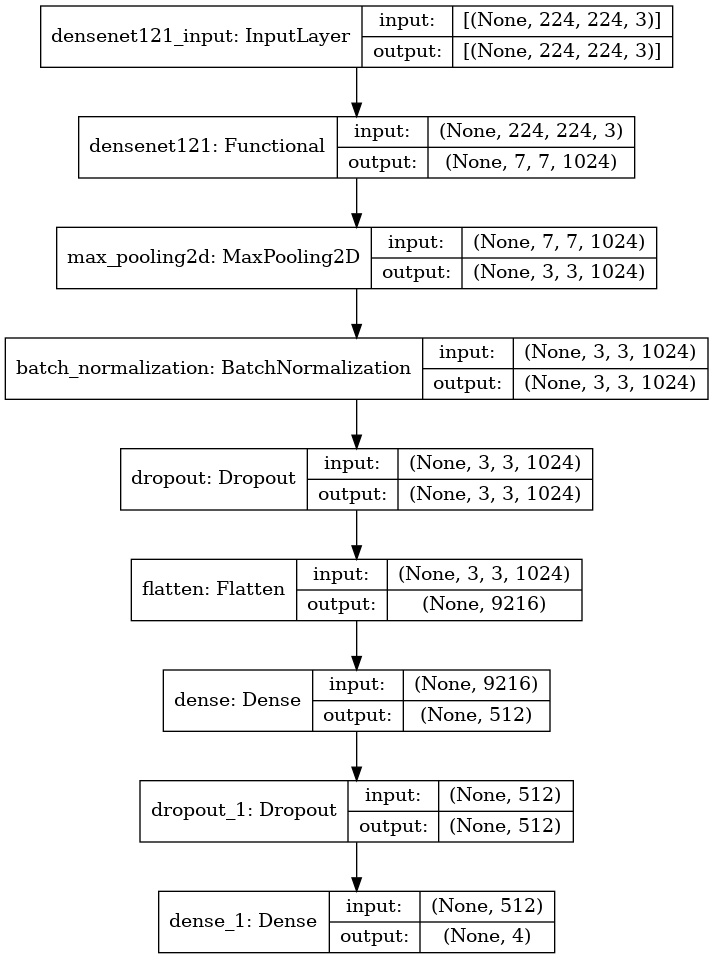

In [16]:
from tensorflow.keras.utils import to_categorical, plot_model
plot_model(model, to_file='cnn-plant.png', show_shapes=True)

In [17]:
history = model.fit(train_ds, validation_data = val_ds, epochs = 15, verbose = 1, callbacks = callbacks)

Epoch 1/15


2022-12-31 23:03:04.125956: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
2022-12-31 23:03:11.598892: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


  4/106 [>.............................] - ETA: 22s - loss: 6.0157 - accuracy: 0.3984

Cleanup called...
Cleanup called...


  5/106 [>.............................] - ETA: 26s - loss: 5.3133 - accuracy: 0.4250

Cleanup called...
Cleanup called...


  7/106 [>.............................] - ETA: 27s - loss: 5.4291 - accuracy: 0.3929

Cleanup called...
Cleanup called...
Cleanup called...


  8/106 [=>............................] - ETA: 29s - loss: 5.2966 - accuracy: 0.3945

Cleanup called...


 11/106 [==>...........................] - ETA: 25s - loss: 4.8418 - accuracy: 0.4148

Cleanup called...


 12/106 [==>...........................] - ETA: 24s - loss: 4.7531 - accuracy: 0.4062

Cleanup called...
Cleanup called...


 13/106 [==>...........................] - ETA: 25s - loss: 4.5549 - accuracy: 0.4135

Cleanup called...
Cleanup called...


 14/106 [==>...........................] - ETA: 25s - loss: 4.3697 - accuracy: 0.4152

Cleanup called...


 17/106 [===>..........................] - ETA: 24s - loss: 4.0184 - accuracy: 0.4301

Cleanup called...
Cleanup called...
Cleanup called...


 18/106 [====>.........................] - ETA: 24s - loss: 3.9094 - accuracy: 0.4323

Cleanup called...
Cleanup called...


 19/106 [====>.........................] - ETA: 24s - loss: 4.0176 - accuracy: 0.4441

Cleanup called...


 22/106 [=====>........................] - ETA: 22s - loss: 3.7058 - accuracy: 0.4560

Cleanup called...
Cleanup called...


 25/106 [======>.......................] - ETA: 21s - loss: 3.4107 - accuracy: 0.4737

Cleanup called...
Cleanup called...


 26/106 [======>.......................] - ETA: 21s - loss: 3.3043 - accuracy: 0.4820

Cleanup called...
Cleanup called...


 27/106 [======>.......................] - ETA: 20s - loss: 3.2158 - accuracy: 0.4942

Cleanup called...
Cleanup called...


 29/106 [=======>......................] - ETA: 20s - loss: 3.0312 - accuracy: 0.5129

Cleanup called...
Cleanup called...


 30/106 [=======>......................] - ETA: 20s - loss: 2.9693 - accuracy: 0.5177

Cleanup called...
Cleanup called...
Cleanup called...


 31/106 [=======>......................] - ETA: 20s - loss: 2.8990 - accuracy: 0.5222

Cleanup called...
Cleanup called...


 32/106 [========>.....................] - ETA: 20s - loss: 2.8308 - accuracy: 0.5283

Cleanup called...


 33/106 [========>.....................] - ETA: 19s - loss: 2.7726 - accuracy: 0.5322

Cleanup called...
Cleanup called...


 34/106 [========>.....................] - ETA: 19s - loss: 2.7114 - accuracy: 0.5386

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 35/106 [========>.....................] - ETA: 19s - loss: 2.6712 - accuracy: 0.5411

Cleanup called...
Cleanup called...


 36/106 [=========>....................] - ETA: 19s - loss: 2.6365 - accuracy: 0.5425

Cleanup called...
Cleanup called...


 38/106 [=========>....................] - ETA: 19s - loss: 2.5611 - accuracy: 0.5485

Cleanup called...


 39/106 [==========>...................] - ETA: 18s - loss: 2.5157 - accuracy: 0.5529

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 40/106 [==========>...................] - ETA: 18s - loss: 2.4818 - accuracy: 0.5562

Cleanup called...
Cleanup called...


 41/106 [==========>...................] - ETA: 18s - loss: 2.4488 - accuracy: 0.5579

Cleanup called...


 42/106 [==========>...................] - ETA: 18s - loss: 2.4264 - accuracy: 0.5551

Cleanup called...


 43/106 [===========>..................] - ETA: 18s - loss: 2.4025 - accuracy: 0.5552

Cleanup called...


 45/106 [===========>..................] - ETA: 17s - loss: 2.3222 - accuracy: 0.5667

Cleanup called...
Cleanup called...


 46/106 [============>.................] - ETA: 17s - loss: 2.2934 - accuracy: 0.5686

Cleanup called...
Cleanup called...


 48/106 [============>.................] - ETA: 16s - loss: 2.2320 - accuracy: 0.5729

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 49/106 [============>.................] - ETA: 16s - loss: 2.2040 - accuracy: 0.5753

Cleanup called...
Cleanup called...


 50/106 [=============>................] - ETA: 16s - loss: 2.2054 - accuracy: 0.5744

Cleanup called...


 51/106 [=============>................] - ETA: 16s - loss: 2.1802 - accuracy: 0.5748

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 52/106 [=============>................] - ETA: 16s - loss: 2.1559 - accuracy: 0.5763

Cleanup called...
Cleanup called...


 53/106 [==============>...............] - ETA: 15s - loss: 2.1368 - accuracy: 0.5790

Cleanup called...


 54/106 [==============>...............] - ETA: 15s - loss: 2.1075 - accuracy: 0.5828

Cleanup called...
Cleanup called...


 55/106 [==============>...............] - ETA: 15s - loss: 2.0825 - accuracy: 0.5869

Cleanup called...
Cleanup called...


 56/106 [==============>...............] - ETA: 15s - loss: 2.0626 - accuracy: 0.5893

Cleanup called...
Cleanup called...


 57/106 [===============>..............] - ETA: 14s - loss: 2.0363 - accuracy: 0.5932

Cleanup called...


 58/106 [===============>..............] - ETA: 14s - loss: 2.0138 - accuracy: 0.5975

Cleanup called...
Cleanup called...


 59/106 [===============>..............] - ETA: 14s - loss: 1.9940 - accuracy: 0.5985

Cleanup called...
Cleanup called...
Cleanup called...


 60/106 [===============>..............] - ETA: 13s - loss: 1.9720 - accuracy: 0.6016

Cleanup called...
Cleanup called...
Cleanup called...


 62/106 [================>.............] - ETA: 13s - loss: 1.9279 - accuracy: 0.6058

Cleanup called...
Cleanup called...


 63/106 [================>.............] - ETA: 13s - loss: 1.9188 - accuracy: 0.6076

Cleanup called...
Cleanup called...


 64/106 [=================>............] - ETA: 12s - loss: 1.9174 - accuracy: 0.6060

Cleanup called...


 66/106 [=================>............] - ETA: 12s - loss: 1.8874 - accuracy: 0.6065

Cleanup called...


 67/106 [=================>............] - ETA: 11s - loss: 1.8750 - accuracy: 0.6068

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 68/106 [==================>...........] - ETA: 11s - loss: 1.8658 - accuracy: 0.6075

Cleanup called...


 70/106 [==================>...........] - ETA: 10s - loss: 1.8424 - accuracy: 0.6098

Cleanup called...
Cleanup called...


 71/106 [===================>..........] - ETA: 10s - loss: 1.8283 - accuracy: 0.6109

Cleanup called...
Cleanup called...


 72/106 [===================>..........] - ETA: 10s - loss: 1.8089 - accuracy: 0.6133

Cleanup called...
Cleanup called...


 73/106 [===================>..........] - ETA: 9s - loss: 1.7906 - accuracy: 0.6152 

Cleanup called...
Cleanup called...


 75/106 [====================>.........] - ETA: 9s - loss: 1.7788 - accuracy: 0.6154

Cleanup called...
Cleanup called...


 76/106 [====================>.........] - ETA: 9s - loss: 1.7700 - accuracy: 0.6155

Cleanup called...
Cleanup called...


 77/106 [====================>.........] - ETA: 8s - loss: 1.7753 - accuracy: 0.6169

Cleanup called...
Cleanup called...
Cleanup called...


 78/106 [=====================>........] - ETA: 8s - loss: 1.7626 - accuracy: 0.6186

Cleanup called...
Cleanup called...


 80/106 [=====================>........] - ETA: 7s - loss: 1.7496 - accuracy: 0.6203

Cleanup called...
Cleanup called...


 81/106 [=====================>........] - ETA: 7s - loss: 1.7325 - accuracy: 0.6235

Cleanup called...


 82/106 [======================>.......] - ETA: 7s - loss: 1.7202 - accuracy: 0.6242

Cleanup called...


 83/106 [======================>.......] - ETA: 6s - loss: 1.7052 - accuracy: 0.6258

Cleanup called...


 84/106 [======================>.......] - ETA: 6s - loss: 1.6978 - accuracy: 0.6272

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 85/106 [=======================>......] - ETA: 6s - loss: 1.6871 - accuracy: 0.6287

Cleanup called...


 86/106 [=======================>......] - ETA: 6s - loss: 1.6716 - accuracy: 0.6308

Cleanup called...
Cleanup called...


 88/106 [=======================>......] - ETA: 5s - loss: 1.6479 - accuracy: 0.6328

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 89/106 [========================>.....] - ETA: 5s - loss: 1.6376 - accuracy: 0.6338

Cleanup called...
Cleanup called...
Cleanup called...


 91/106 [========================>.....] - ETA: 4s - loss: 1.6139 - accuracy: 0.6370

Cleanup called...


 95/106 [=========================>....] - ETA: 3s - loss: 1.5700 - accuracy: 0.6444

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 96/106 [==========================>...] - ETA: 3s - loss: 1.5669 - accuracy: 0.6439

Cleanup called...


 98/106 [==========================>...] - ETA: 2s - loss: 1.5497 - accuracy: 0.6464

Cleanup called...


106/106 [==============================] - ETA: 0s - loss: 1.4763 - accuracy: 0.6565

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


106/106 [==============================] - 65s 384ms/step - loss: 1.4763 - accuracy: 0.6565 - val_loss: 9.1562 - val_accuracy: 0.6797
Epoch 2/15


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


  1/106 [..............................] - ETA: 3:15 - loss: 0.5745 - accuracy: 0.8125

Cleanup called...


  4/106 [>.............................] - ETA: 31s - loss: 0.4941 - accuracy: 0.8438

Cleanup called...
Cleanup called...


  5/106 [>.............................] - ETA: 32s - loss: 0.4296 - accuracy: 0.8625

Cleanup called...
Cleanup called...
Cleanup called...


  7/106 [>.............................] - ETA: 27s - loss: 0.4121 - accuracy: 0.8705

Cleanup called...
Cleanup called...
Cleanup called...


 11/106 [==>...........................] - ETA: 22s - loss: 0.5202 - accuracy: 0.8381

Cleanup called...
Cleanup called...


 13/106 [==>...........................] - ETA: 20s - loss: 0.5707 - accuracy: 0.8221

Cleanup called...
Cleanup called...


 14/106 [==>...........................] - ETA: 20s - loss: 0.6023 - accuracy: 0.8080

Cleanup called...
Cleanup called...


 17/106 [===>..........................] - ETA: 18s - loss: 0.5982 - accuracy: 0.8070

Cleanup called...
Cleanup called...


 18/106 [====>.........................] - ETA: 18s - loss: 0.5987 - accuracy: 0.8090

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 21/106 [====>.........................] - ETA: 17s - loss: 0.6152 - accuracy: 0.8065

Cleanup called...
Cleanup called...


 25/106 [======>.......................] - ETA: 15s - loss: 0.6395 - accuracy: 0.7887

Cleanup called...
Cleanup called...


 26/106 [======>.......................] - ETA: 15s - loss: 0.6235 - accuracy: 0.7933

Cleanup called...
Cleanup called...


 27/106 [======>.......................] - ETA: 14s - loss: 0.6181 - accuracy: 0.7963

Cleanup called...
Cleanup called...


 29/106 [=======>......................] - ETA: 14s - loss: 0.6471 - accuracy: 0.7920

Cleanup called...
Cleanup called...


 30/106 [=======>......................] - ETA: 14s - loss: 0.6618 - accuracy: 0.7896

Cleanup called...
Cleanup called...
Cleanup called...


 31/106 [=======>......................] - ETA: 14s - loss: 0.6760 - accuracy: 0.7833

Cleanup called...
Cleanup called...
Cleanup called...


 33/106 [========>.....................] - ETA: 14s - loss: 0.6876 - accuracy: 0.7794

Cleanup called...
Cleanup called...
Cleanup called...


 34/106 [========>.....................] - ETA: 13s - loss: 0.6773 - accuracy: 0.7812

Cleanup called...
Cleanup called...
Cleanup called...


 35/106 [========>.....................] - ETA: 13s - loss: 0.6661 - accuracy: 0.7839

Cleanup called...
Cleanup called...
Cleanup called...


 37/106 [=========>....................] - ETA: 13s - loss: 0.6532 - accuracy: 0.7880

Cleanup called...
Cleanup called...


 39/106 [==========>...................] - ETA: 13s - loss: 0.6371 - accuracy: 0.7917

Cleanup called...
Cleanup called...
Cleanup called...


 40/106 [==========>...................] - ETA: 13s - loss: 0.6277 - accuracy: 0.7937

Cleanup called...
Cleanup called...
Cleanup called...


 41/106 [==========>...................] - ETA: 12s - loss: 0.6205 - accuracy: 0.7965

Cleanup called...
Cleanup called...


 43/106 [===========>..................] - ETA: 12s - loss: 0.6125 - accuracy: 0.7980

Cleanup called...


 45/106 [===========>..................] - ETA: 11s - loss: 0.6198 - accuracy: 0.7951

Cleanup called...
Cleanup called...


 47/106 [============>.................] - ETA: 11s - loss: 0.6129 - accuracy: 0.7952

Cleanup called...
Cleanup called...


 48/106 [============>.................] - ETA: 11s - loss: 0.6083 - accuracy: 0.7962

Cleanup called...
Cleanup called...
Cleanup called...


 49/106 [============>.................] - ETA: 11s - loss: 0.6102 - accuracy: 0.7966

Cleanup called...
Cleanup called...
Cleanup called...


 50/106 [=============>................] - ETA: 11s - loss: 0.6078 - accuracy: 0.7962

Cleanup called...
Cleanup called...


 51/106 [=============>................] - ETA: 10s - loss: 0.6178 - accuracy: 0.7935

Cleanup called...
Cleanup called...
Cleanup called...


 52/106 [=============>................] - ETA: 10s - loss: 0.6268 - accuracy: 0.7927

Cleanup called...
Cleanup called...


 53/106 [==============>...............] - ETA: 10s - loss: 0.6235 - accuracy: 0.7936

Cleanup called...
Cleanup called...


 54/106 [==============>...............] - ETA: 10s - loss: 0.6175 - accuracy: 0.7963

Cleanup called...
Cleanup called...
Cleanup called...


 55/106 [==============>...............] - ETA: 10s - loss: 0.6144 - accuracy: 0.7977

Cleanup called...
Cleanup called...


 57/106 [===============>..............] - ETA: 9s - loss: 0.6098 - accuracy: 0.7971 

Cleanup called...
Cleanup called...


 58/106 [===============>..............] - ETA: 9s - loss: 0.6188 - accuracy: 0.7963

Cleanup called...
Cleanup called...


 59/106 [===============>..............] - ETA: 9s - loss: 0.6124 - accuracy: 0.7987

Cleanup called...
Cleanup called...
Cleanup called...


 60/106 [===============>..............] - ETA: 9s - loss: 0.6078 - accuracy: 0.8005

Cleanup called...
Cleanup called...


 61/106 [================>.............] - ETA: 9s - loss: 0.6034 - accuracy: 0.8017

Cleanup called...
Cleanup called...


 62/106 [================>.............] - ETA: 8s - loss: 0.6005 - accuracy: 0.8019

Cleanup called...
Cleanup called...


 63/106 [================>.............] - ETA: 8s - loss: 0.5999 - accuracy: 0.8026

Cleanup called...
Cleanup called...


 66/106 [=================>............] - ETA: 8s - loss: 0.6040 - accuracy: 0.8007

Cleanup called...


 67/106 [=================>............] - ETA: 7s - loss: 0.5981 - accuracy: 0.8018

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 68/106 [==================>...........] - ETA: 7s - loss: 0.5958 - accuracy: 0.8019

Cleanup called...
Cleanup called...


 70/106 [==================>...........] - ETA: 7s - loss: 0.6018 - accuracy: 0.7991

Cleanup called...
Cleanup called...


 71/106 [===================>..........] - ETA: 7s - loss: 0.6018 - accuracy: 0.7997

Cleanup called...
Cleanup called...


 72/106 [===================>..........] - ETA: 6s - loss: 0.6106 - accuracy: 0.7982

Cleanup called...
Cleanup called...


 73/106 [===================>..........] - ETA: 6s - loss: 0.6130 - accuracy: 0.7971

Cleanup called...
Cleanup called...


 75/106 [====================>.........] - ETA: 6s - loss: 0.6151 - accuracy: 0.7954

Cleanup called...
Cleanup called...
Cleanup called...


 76/106 [====================>.........] - ETA: 6s - loss: 0.6147 - accuracy: 0.7956

Cleanup called...
Cleanup called...


 77/106 [====================>.........] - ETA: 5s - loss: 0.6112 - accuracy: 0.7963

Cleanup called...
Cleanup called...


 78/106 [=====================>........] - ETA: 5s - loss: 0.6080 - accuracy: 0.7969

Cleanup called...
Cleanup called...


 80/106 [=====================>........] - ETA: 5s - loss: 0.6059 - accuracy: 0.7996

Cleanup called...
Cleanup called...
Cleanup called...


 82/106 [======================>.......] - ETA: 4s - loss: 0.5994 - accuracy: 0.8011

Cleanup called...
Cleanup called...


 84/106 [======================>.......] - ETA: 4s - loss: 0.5914 - accuracy: 0.8032

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 86/106 [=======================>......] - ETA: 4s - loss: 0.5879 - accuracy: 0.8049

Cleanup called...
Cleanup called...


 88/106 [=======================>......] - ETA: 3s - loss: 0.5816 - accuracy: 0.8072

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 90/106 [========================>.....] - ETA: 3s - loss: 0.5815 - accuracy: 0.8087

Cleanup called...
Cleanup called...
Cleanup called...


 94/106 [=========================>....] - ETA: 2s - loss: 0.5816 - accuracy: 0.8082

Cleanup called...
Cleanup called...


 95/106 [=========================>....] - ETA: 2s - loss: 0.5811 - accuracy: 0.8079

Cleanup called...
Cleanup called...
Cleanup called...


 96/106 [==========================>...] - ETA: 1s - loss: 0.5779 - accuracy: 0.8089

Cleanup called...
Cleanup called...


 98/106 [==========================>...] - ETA: 1s - loss: 0.5770 - accuracy: 0.8096

Cleanup called...


106/106 [==============================] - ETA: 0s - loss: 0.5638 - accuracy: 0.8151

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


106/106 [==============================] - 26s 234ms/step - loss: 0.5638 - accuracy: 0.8151 - val_loss: 1665.5703 - val_accuracy: 0.4116

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 3/15


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


  4/106 [>.............................] - ETA: 15s - loss: 0.5029 - accuracy: 0.8281

Cleanup called...
Cleanup called...


  5/106 [>.............................] - ETA: 19s - loss: 0.4609 - accuracy: 0.8438

Cleanup called...
Cleanup called...
Cleanup called...


  7/106 [>.............................] - ETA: 18s - loss: 0.4333 - accuracy: 0.8482

Cleanup called...
Cleanup called...
Cleanup called...


 10/106 [=>............................] - ETA: 17s - loss: 0.3854 - accuracy: 0.8687

Cleanup called...
Cleanup called...


 13/106 [==>...........................] - ETA: 16s - loss: 0.3886 - accuracy: 0.8654

Cleanup called...
Cleanup called...


 14/106 [==>...........................] - ETA: 16s - loss: 0.3846 - accuracy: 0.8705

Cleanup called...
Cleanup called...


 17/106 [===>..........................] - ETA: 15s - loss: 0.3595 - accuracy: 0.8787

Cleanup called...
Cleanup called...


 18/106 [====>.........................] - ETA: 16s - loss: 0.3642 - accuracy: 0.8750

Cleanup called...
Cleanup called...
Cleanup called...


 19/106 [====>.........................] - ETA: 16s - loss: 0.3636 - accuracy: 0.8766

Cleanup called...


 21/106 [====>.........................] - ETA: 15s - loss: 0.3549 - accuracy: 0.8765

Cleanup called...
Cleanup called...


 25/106 [======>.......................] - ETA: 14s - loss: 0.3597 - accuracy: 0.8775

Cleanup called...
Cleanup called...


 26/106 [======>.......................] - ETA: 14s - loss: 0.3635 - accuracy: 0.8750

Cleanup called...
Cleanup called...


 27/106 [======>.......................] - ETA: 14s - loss: 0.3597 - accuracy: 0.8762

Cleanup called...
Cleanup called...


 29/106 [=======>......................] - ETA: 14s - loss: 0.3530 - accuracy: 0.8772

Cleanup called...
Cleanup called...


 30/106 [=======>......................] - ETA: 14s - loss: 0.3492 - accuracy: 0.8781

Cleanup called...
Cleanup called...
Cleanup called...


 31/106 [=======>......................] - ETA: 14s - loss: 0.3440 - accuracy: 0.8810

Cleanup called...
Cleanup called...
Cleanup called...


 33/106 [========>.....................] - ETA: 13s - loss: 0.3404 - accuracy: 0.8826

Cleanup called...
Cleanup called...
Cleanup called...


 34/106 [========>.....................] - ETA: 13s - loss: 0.3349 - accuracy: 0.8842

Cleanup called...
Cleanup called...
Cleanup called...


 35/106 [========>.....................] - ETA: 13s - loss: 0.3387 - accuracy: 0.8839

Cleanup called...
Cleanup called...
Cleanup called...


 37/106 [=========>....................] - ETA: 13s - loss: 0.3365 - accuracy: 0.8834

Cleanup called...
Cleanup called...


 39/106 [==========>...................] - ETA: 12s - loss: 0.3343 - accuracy: 0.8838

Cleanup called...
Cleanup called...
Cleanup called...


 40/106 [==========>...................] - ETA: 12s - loss: 0.3353 - accuracy: 0.8836

Cleanup called...
Cleanup called...
Cleanup called...


 41/106 [==========>...................] - ETA: 12s - loss: 0.3373 - accuracy: 0.8849

Cleanup called...
Cleanup called...


 43/106 [===========>..................] - ETA: 12s - loss: 0.3333 - accuracy: 0.8844

Cleanup called...


 45/106 [===========>..................] - ETA: 11s - loss: 0.3251 - accuracy: 0.8868

Cleanup called...
Cleanup called...


 47/106 [============>.................] - ETA: 11s - loss: 0.3224 - accuracy: 0.8876

Cleanup called...
Cleanup called...


 48/106 [============>.................] - ETA: 10s - loss: 0.3299 - accuracy: 0.8854

Cleanup called...
Cleanup called...
Cleanup called...


 49/106 [============>.................] - ETA: 10s - loss: 0.3294 - accuracy: 0.8865

Cleanup called...
Cleanup called...
Cleanup called...


 50/106 [=============>................] - ETA: 10s - loss: 0.3366 - accuracy: 0.8844

Cleanup called...
Cleanup called...


 51/106 [=============>................] - ETA: 10s - loss: 0.3339 - accuracy: 0.8860

Cleanup called...
Cleanup called...
Cleanup called...


 52/106 [=============>................] - ETA: 10s - loss: 0.3344 - accuracy: 0.8846

Cleanup called...
Cleanup called...


 53/106 [==============>...............] - ETA: 10s - loss: 0.3344 - accuracy: 0.8850

Cleanup called...
Cleanup called...


 54/106 [==============>...............] - ETA: 10s - loss: 0.3341 - accuracy: 0.8854

Cleanup called...
Cleanup called...
Cleanup called...


 55/106 [==============>...............] - ETA: 10s - loss: 0.3345 - accuracy: 0.8847

Cleanup called...
Cleanup called...


 57/106 [===============>..............] - ETA: 9s - loss: 0.3350 - accuracy: 0.8849

Cleanup called...
Cleanup called...


 58/106 [===============>..............] - ETA: 9s - loss: 0.3313 - accuracy: 0.8858

Cleanup called...
Cleanup called...


 59/106 [===============>..............] - ETA: 9s - loss: 0.3339 - accuracy: 0.8851

Cleanup called...
Cleanup called...
Cleanup called...


 60/106 [===============>..............] - ETA: 9s - loss: 0.3304 - accuracy: 0.8859

Cleanup called...
Cleanup called...


 61/106 [================>.............] - ETA: 8s - loss: 0.3295 - accuracy: 0.8873

Cleanup called...
Cleanup called...


 62/106 [================>.............] - ETA: 8s - loss: 0.3261 - accuracy: 0.8886

Cleanup called...
Cleanup called...


 63/106 [================>.............] - ETA: 8s - loss: 0.3240 - accuracy: 0.8894

Cleanup called...
Cleanup called...


 66/106 [=================>............] - ETA: 7s - loss: 0.3307 - accuracy: 0.8892

Cleanup called...


 67/106 [=================>............] - ETA: 7s - loss: 0.3298 - accuracy: 0.8895

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 68/106 [==================>...........] - ETA: 7s - loss: 0.3314 - accuracy: 0.8883

Cleanup called...
Cleanup called...


 70/106 [==================>...........] - ETA: 7s - loss: 0.3326 - accuracy: 0.8862

Cleanup called...
Cleanup called...


 71/106 [===================>..........] - ETA: 6s - loss: 0.3376 - accuracy: 0.8851

Cleanup called...
Cleanup called...


 72/106 [===================>..........] - ETA: 6s - loss: 0.3368 - accuracy: 0.8850

Cleanup called...
Cleanup called...


 73/106 [===================>..........] - ETA: 6s - loss: 0.3352 - accuracy: 0.8848

Cleanup called...
Cleanup called...


 75/106 [====================>.........] - ETA: 6s - loss: 0.3365 - accuracy: 0.8838

Cleanup called...
Cleanup called...
Cleanup called...


 76/106 [====================>.........] - ETA: 5s - loss: 0.3395 - accuracy: 0.8828

Cleanup called...
Cleanup called...


 77/106 [====================>.........] - ETA: 5s - loss: 0.3406 - accuracy: 0.8823

Cleanup called...
Cleanup called...


 78/106 [=====================>........] - ETA: 5s - loss: 0.3407 - accuracy: 0.8814

Cleanup called...
Cleanup called...


 80/106 [=====================>........] - ETA: 5s - loss: 0.3393 - accuracy: 0.8816

Cleanup called...
Cleanup called...
Cleanup called...


 82/106 [======================>.......] - ETA: 4s - loss: 0.3420 - accuracy: 0.8803

Cleanup called...
Cleanup called...


 84/106 [======================>.......] - ETA: 4s - loss: 0.3395 - accuracy: 0.8813

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 86/106 [=======================>......] - ETA: 3s - loss: 0.3364 - accuracy: 0.8819

Cleanup called...
Cleanup called...


 88/106 [=======================>......] - ETA: 3s - loss: 0.3368 - accuracy: 0.8828

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 90/106 [========================>.....] - ETA: 3s - loss: 0.3332 - accuracy: 0.8844

Cleanup called...
Cleanup called...
Cleanup called...


 94/106 [=========================>....] - ETA: 2s - loss: 0.3316 - accuracy: 0.8846

Cleanup called...
Cleanup called...


 95/106 [=========================>....] - ETA: 2s - loss: 0.3318 - accuracy: 0.8839

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 97/106 [==========================>...] - ETA: 1s - loss: 0.3286 - accuracy: 0.8856

Cleanup called...
Cleanup called...


106/106 [==============================] - ETA: 0s - loss: 0.3261 - accuracy: 0.8886

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


106/106 [==============================] - 27s 237ms/step - loss: 0.3261 - accuracy: 0.8886 - val_loss: 1.4376 - val_accuracy: 0.9205
Epoch 4/15


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


  1/106 [..............................] - ETA: 3:02 - loss: 0.3889 - accuracy: 0.8438

Cleanup called...
Cleanup called...


  4/106 [>.............................] - ETA: 16s - loss: 0.3538 - accuracy: 0.8672

Cleanup called...
Cleanup called...


  5/106 [>.............................] - ETA: 17s - loss: 0.3318 - accuracy: 0.8750

Cleanup called...
Cleanup called...
Cleanup called...


  7/106 [>.............................] - ETA: 17s - loss: 0.2924 - accuracy: 0.9018

Cleanup called...
Cleanup called...
Cleanup called...


 11/106 [==>...........................] - ETA: 16s - loss: 0.2842 - accuracy: 0.9034

Cleanup called...
Cleanup called...


 13/106 [==>...........................] - ETA: 15s - loss: 0.2701 - accuracy: 0.9087

Cleanup called...
Cleanup called...


 14/106 [==>...........................] - ETA: 16s - loss: 0.2586 - accuracy: 0.9107

Cleanup called...
Cleanup called...


 17/106 [===>..........................] - ETA: 15s - loss: 0.2517 - accuracy: 0.9099

Cleanup called...
Cleanup called...


 18/106 [====>.........................] - ETA: 14s - loss: 0.2618 - accuracy: 0.9080

Cleanup called...
Cleanup called...
Cleanup called...


 19/106 [====>.........................] - ETA: 15s - loss: 0.3868 - accuracy: 0.9046

Cleanup called...


 21/106 [====>.........................] - ETA: 14s - loss: 0.3676 - accuracy: 0.9092

Cleanup called...
Cleanup called...


 25/106 [======>.......................] - ETA: 13s - loss: 0.3836 - accuracy: 0.8988

Cleanup called...
Cleanup called...


 27/106 [======>.......................] - ETA: 13s - loss: 0.3698 - accuracy: 0.9005

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 29/106 [=======>......................] - ETA: 12s - loss: 0.3598 - accuracy: 0.9019

Cleanup called...
Cleanup called...


 30/106 [=======>......................] - ETA: 12s - loss: 0.3504 - accuracy: 0.9052

Cleanup called...
Cleanup called...
Cleanup called...


 31/106 [=======>......................] - ETA: 12s - loss: 0.3471 - accuracy: 0.9052

Cleanup called...
Cleanup called...
Cleanup called...


 33/106 [========>.....................] - ETA: 12s - loss: 0.3328 - accuracy: 0.9081

Cleanup called...
Cleanup called...
Cleanup called...


 34/106 [========>.....................] - ETA: 12s - loss: 0.3333 - accuracy: 0.9062

Cleanup called...
Cleanup called...
Cleanup called...


 35/106 [========>.....................] - ETA: 12s - loss: 0.3382 - accuracy: 0.9036

Cleanup called...
Cleanup called...
Cleanup called...


 37/106 [=========>....................] - ETA: 12s - loss: 0.3423 - accuracy: 0.8995

Cleanup called...
Cleanup called...


 39/106 [==========>...................] - ETA: 11s - loss: 0.3358 - accuracy: 0.8998

Cleanup called...
Cleanup called...
Cleanup called...


 40/106 [==========>...................] - ETA: 11s - loss: 0.3281 - accuracy: 0.9023

Cleanup called...
Cleanup called...
Cleanup called...


 41/106 [==========>...................] - ETA: 11s - loss: 0.3251 - accuracy: 0.9032

Cleanup called...
Cleanup called...


 43/106 [===========>..................] - ETA: 11s - loss: 0.3168 - accuracy: 0.9048

Cleanup called...


 45/106 [===========>..................] - ETA: 11s - loss: 0.3162 - accuracy: 0.9049

Cleanup called...
Cleanup called...


 47/106 [============>.................] - ETA: 10s - loss: 0.3139 - accuracy: 0.9049

Cleanup called...
Cleanup called...


 48/106 [============>.................] - ETA: 10s - loss: 0.3162 - accuracy: 0.9036

Cleanup called...
Cleanup called...
Cleanup called...


 49/106 [============>.................] - ETA: 10s - loss: 0.3127 - accuracy: 0.9050

Cleanup called...
Cleanup called...
Cleanup called...


 50/106 [=============>................] - ETA: 10s - loss: 0.3097 - accuracy: 0.9050

Cleanup called...
Cleanup called...


 51/106 [=============>................] - ETA: 10s - loss: 0.3113 - accuracy: 0.9050

Cleanup called...
Cleanup called...
Cleanup called...


 52/106 [=============>................] - ETA: 10s - loss: 0.3098 - accuracy: 0.9050

Cleanup called...
Cleanup called...


 53/106 [==============>...............] - ETA: 9s - loss: 0.3063 - accuracy: 0.9057 

Cleanup called...
Cleanup called...


 54/106 [==============>...............] - ETA: 9s - loss: 0.3085 - accuracy: 0.9057

Cleanup called...
Cleanup called...
Cleanup called...


 55/106 [==============>...............] - ETA: 9s - loss: 0.3081 - accuracy: 0.9051

Cleanup called...
Cleanup called...


 57/106 [===============>..............] - ETA: 9s - loss: 0.3214 - accuracy: 0.9019

Cleanup called...
Cleanup called...


 58/106 [===============>..............] - ETA: 9s - loss: 0.3249 - accuracy: 0.8982

Cleanup called...
Cleanup called...


 59/106 [===============>..............] - ETA: 8s - loss: 0.3235 - accuracy: 0.8978

Cleanup called...
Cleanup called...
Cleanup called...


 60/106 [===============>..............] - ETA: 8s - loss: 0.3222 - accuracy: 0.8974

Cleanup called...
Cleanup called...


 61/106 [================>.............] - ETA: 8s - loss: 0.3229 - accuracy: 0.8965

Cleanup called...
Cleanup called...


 62/106 [================>.............] - ETA: 8s - loss: 0.3208 - accuracy: 0.8972

Cleanup called...
Cleanup called...


 63/106 [================>.............] - ETA: 8s - loss: 0.3212 - accuracy: 0.8973

Cleanup called...
Cleanup called...


 65/106 [=================>............] - ETA: 8s - loss: 0.3222 - accuracy: 0.8962

Cleanup called...


 67/106 [=================>............] - ETA: 7s - loss: 0.3180 - accuracy: 0.8974

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 68/106 [==================>...........] - ETA: 7s - loss: 0.3165 - accuracy: 0.8975

Cleanup called...
Cleanup called...


 70/106 [==================>...........] - ETA: 7s - loss: 0.3153 - accuracy: 0.8978

Cleanup called...
Cleanup called...


 71/106 [===================>..........] - ETA: 6s - loss: 0.3150 - accuracy: 0.8974

Cleanup called...
Cleanup called...


 72/106 [===================>..........] - ETA: 6s - loss: 0.3143 - accuracy: 0.8971

Cleanup called...
Cleanup called...


 73/106 [===================>..........] - ETA: 6s - loss: 0.3118 - accuracy: 0.8973

Cleanup called...
Cleanup called...


 75/106 [====================>.........] - ETA: 6s - loss: 0.3118 - accuracy: 0.8975

Cleanup called...
Cleanup called...
Cleanup called...


 76/106 [====================>.........] - ETA: 5s - loss: 0.3134 - accuracy: 0.8972

Cleanup called...
Cleanup called...


 77/106 [====================>.........] - ETA: 5s - loss: 0.3132 - accuracy: 0.8969

Cleanup called...
Cleanup called...
Cleanup called...


 79/106 [=====================>........] - ETA: 5s - loss: 0.3160 - accuracy: 0.8948

Cleanup called...


 80/106 [=====================>........] - ETA: 5s - loss: 0.3155 - accuracy: 0.8949

Cleanup called...
Cleanup called...
Cleanup called...


 82/106 [======================>.......] - ETA: 4s - loss: 0.3165 - accuracy: 0.8925

Cleanup called...
Cleanup called...


 84/106 [======================>.......] - ETA: 4s - loss: 0.3135 - accuracy: 0.8925

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 86/106 [=======================>......] - ETA: 3s - loss: 0.3119 - accuracy: 0.8932

Cleanup called...
Cleanup called...


 88/106 [=======================>......] - ETA: 3s - loss: 0.3122 - accuracy: 0.8931

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 89/106 [========================>.....] - ETA: 3s - loss: 0.3124 - accuracy: 0.8929

Cleanup called...
Cleanup called...
Cleanup called...


 91/106 [========================>.....] - ETA: 3s - loss: 0.3096 - accuracy: 0.8942

Cleanup called...


 93/106 [=========================>....] - ETA: 2s - loss: 0.3043 - accuracy: 0.8962

Cleanup called...


 95/106 [=========================>....] - ETA: 2s - loss: 0.3006 - accuracy: 0.8974

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 98/106 [==========================>...] - ETA: 1s - loss: 0.2995 - accuracy: 0.8973

Cleanup called...


106/106 [==============================] - ETA: 0s - loss: 0.2928 - accuracy: 0.9010

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


106/106 [==============================] - 26s 234ms/step - loss: 0.2928 - accuracy: 0.9010 - val_loss: 0.4726 - val_accuracy: 0.8885
Epoch 5/15


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


  2/106 [..............................] - ETA: 16s - loss: 0.1550 - accuracy: 0.9375 

Cleanup called...


  4/106 [>.............................] - ETA: 15s - loss: 0.1380 - accuracy: 0.9609

Cleanup called...
Cleanup called...
Cleanup called...


  6/106 [>.............................] - ETA: 19s - loss: 0.1807 - accuracy: 0.9531

Cleanup called...
Cleanup called...


  7/106 [>.............................] - ETA: 18s - loss: 0.1913 - accuracy: 0.9464

Cleanup called...
Cleanup called...
Cleanup called...


 11/106 [==>...........................] - ETA: 17s - loss: 0.2319 - accuracy: 0.9233

Cleanup called...


 12/106 [==>...........................] - ETA: 16s - loss: 0.2479 - accuracy: 0.9115

Cleanup called...
Cleanup called...


 14/106 [==>...........................] - ETA: 16s - loss: 0.3057 - accuracy: 0.9018

Cleanup called...
Cleanup called...
Cleanup called...


 16/106 [===>..........................] - ETA: 16s - loss: 0.3198 - accuracy: 0.8965

Cleanup called...


 17/106 [===>..........................] - ETA: 16s - loss: 0.3118 - accuracy: 0.8989

Cleanup called...
Cleanup called...


 18/106 [====>.........................] - ETA: 16s - loss: 0.3148 - accuracy: 0.8958

Cleanup called...
Cleanup called...
Cleanup called...


 21/106 [====>.........................] - ETA: 17s - loss: 0.3096 - accuracy: 0.8973

Cleanup called...
Cleanup called...


 25/106 [======>.......................] - ETA: 15s - loss: 0.2833 - accuracy: 0.9075

Cleanup called...
Cleanup called...


 27/106 [======>.......................] - ETA: 14s - loss: 0.2732 - accuracy: 0.9109

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 29/106 [=======>......................] - ETA: 14s - loss: 0.2729 - accuracy: 0.9116

Cleanup called...
Cleanup called...


 30/106 [=======>......................] - ETA: 14s - loss: 0.2856 - accuracy: 0.9104

Cleanup called...
Cleanup called...
Cleanup called...


 31/106 [=======>......................] - ETA: 14s - loss: 0.2944 - accuracy: 0.9093

Cleanup called...
Cleanup called...
Cleanup called...


 33/106 [========>.....................] - ETA: 13s - loss: 0.2923 - accuracy: 0.9053

Cleanup called...
Cleanup called...
Cleanup called...


 34/106 [========>.....................] - ETA: 13s - loss: 0.2867 - accuracy: 0.9062

Cleanup called...
Cleanup called...
Cleanup called...


 35/106 [========>.....................] - ETA: 13s - loss: 0.3216 - accuracy: 0.9062

Cleanup called...
Cleanup called...
Cleanup called...


 37/106 [=========>....................] - ETA: 13s - loss: 0.3206 - accuracy: 0.9054

Cleanup called...
Cleanup called...


 39/106 [==========>...................] - ETA: 12s - loss: 0.3193 - accuracy: 0.9062

Cleanup called...
Cleanup called...
Cleanup called...


 40/106 [==========>...................] - ETA: 12s - loss: 0.3174 - accuracy: 0.9062

Cleanup called...
Cleanup called...
Cleanup called...


 41/106 [==========>...................] - ETA: 12s - loss: 0.3130 - accuracy: 0.9078

Cleanup called...
Cleanup called...


 43/106 [===========>..................] - ETA: 12s - loss: 0.3111 - accuracy: 0.9084

Cleanup called...


 45/106 [===========>..................] - ETA: 11s - loss: 0.3289 - accuracy: 0.9056

Cleanup called...
Cleanup called...


 47/106 [============>.................] - ETA: 11s - loss: 0.3264 - accuracy: 0.9043

Cleanup called...
Cleanup called...


 48/106 [============>.................] - ETA: 10s - loss: 0.3240 - accuracy: 0.9036

Cleanup called...
Cleanup called...
Cleanup called...


 49/106 [============>.................] - ETA: 10s - loss: 0.3229 - accuracy: 0.9037

Cleanup called...
Cleanup called...
Cleanup called...


 50/106 [=============>................] - ETA: 10s - loss: 0.3244 - accuracy: 0.9031

Cleanup called...
Cleanup called...


 51/106 [=============>................] - ETA: 10s - loss: 0.3236 - accuracy: 0.9026

Cleanup called...
Cleanup called...
Cleanup called...


 52/106 [=============>................] - ETA: 10s - loss: 0.3210 - accuracy: 0.9032

Cleanup called...
Cleanup called...


 53/106 [==============>...............] - ETA: 10s - loss: 0.3236 - accuracy: 0.9027

Cleanup called...
Cleanup called...


 54/106 [==============>...............] - ETA: 10s - loss: 0.3259 - accuracy: 0.9022

Cleanup called...
Cleanup called...
Cleanup called...


 55/106 [==============>...............] - ETA: 10s - loss: 0.3242 - accuracy: 0.9023

Cleanup called...
Cleanup called...


 57/106 [===============>..............] - ETA: 9s - loss: 0.3200 - accuracy: 0.9030 

Cleanup called...
Cleanup called...


 58/106 [===============>..............] - ETA: 9s - loss: 0.3221 - accuracy: 0.9030

Cleanup called...
Cleanup called...


 59/106 [===============>..............] - ETA: 9s - loss: 0.3184 - accuracy: 0.9041

Cleanup called...
Cleanup called...
Cleanup called...


 60/106 [===============>..............] - ETA: 9s - loss: 0.3165 - accuracy: 0.9042

Cleanup called...
Cleanup called...


 61/106 [================>.............] - ETA: 9s - loss: 0.3147 - accuracy: 0.9047

Cleanup called...
Cleanup called...


 62/106 [================>.............] - ETA: 8s - loss: 0.3117 - accuracy: 0.9057

Cleanup called...
Cleanup called...


 63/106 [================>.............] - ETA: 8s - loss: 0.3093 - accuracy: 0.9053

Cleanup called...
Cleanup called...


 65/106 [=================>............] - ETA: 8s - loss: 0.3074 - accuracy: 0.9048

Cleanup called...


 67/106 [=================>............] - ETA: 7s - loss: 0.3058 - accuracy: 0.9058

Cleanup called...
Cleanup called...
Cleanup called...


 68/106 [==================>...........] - ETA: 7s - loss: 0.3025 - accuracy: 0.9067

Cleanup called...
Cleanup called...
Cleanup called...


 70/106 [==================>...........] - ETA: 7s - loss: 0.3013 - accuracy: 0.9067

Cleanup called...
Cleanup called...


 71/106 [===================>..........] - ETA: 6s - loss: 0.2992 - accuracy: 0.9067

Cleanup called...
Cleanup called...


 72/106 [===================>..........] - ETA: 6s - loss: 0.3007 - accuracy: 0.9062

Cleanup called...
Cleanup called...


 73/106 [===================>..........] - ETA: 6s - loss: 0.3042 - accuracy: 0.9054

Cleanup called...
Cleanup called...


 75/106 [====================>.........] - ETA: 6s - loss: 0.3063 - accuracy: 0.9042

Cleanup called...
Cleanup called...
Cleanup called...


 76/106 [====================>.........] - ETA: 5s - loss: 0.3095 - accuracy: 0.9030

Cleanup called...
Cleanup called...


 77/106 [====================>.........] - ETA: 5s - loss: 0.3105 - accuracy: 0.9022

Cleanup called...
Cleanup called...
Cleanup called...


 79/106 [=====================>........] - ETA: 5s - loss: 0.3068 - accuracy: 0.9035

Cleanup called...


 80/106 [=====================>........] - ETA: 5s - loss: 0.3069 - accuracy: 0.9039

Cleanup called...
Cleanup called...
Cleanup called...


 82/106 [======================>.......] - ETA: 4s - loss: 0.3050 - accuracy: 0.9040

Cleanup called...
Cleanup called...


 84/106 [======================>.......] - ETA: 4s - loss: 0.3043 - accuracy: 0.9033

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 86/106 [=======================>......] - ETA: 3s - loss: 0.3020 - accuracy: 0.9026

Cleanup called...
Cleanup called...


 88/106 [=======================>......] - ETA: 3s - loss: 0.3019 - accuracy: 0.9023

Cleanup called...
Cleanup called...


 89/106 [========================>.....] - ETA: 3s - loss: 0.3022 - accuracy: 0.9020

Cleanup called...
Cleanup called...
Cleanup called...


 90/106 [========================>.....] - ETA: 3s - loss: 0.3016 - accuracy: 0.9021

Cleanup called...
Cleanup called...
Cleanup called...


 94/106 [=========================>....] - ETA: 2s - loss: 0.3002 - accuracy: 0.9013

Cleanup called...
Cleanup called...


 95/106 [=========================>....] - ETA: 2s - loss: 0.2975 - accuracy: 0.9023

Cleanup called...
Cleanup called...
Cleanup called...


 96/106 [==========================>...] - ETA: 1s - loss: 0.2962 - accuracy: 0.9027

Cleanup called...
Cleanup called...


 98/106 [==========================>...] - ETA: 1s - loss: 0.3023 - accuracy: 0.9015

Cleanup called...


106/106 [==============================] - ETA: 0s - loss: 0.2958 - accuracy: 0.9031

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


106/106 [==============================] - 26s 233ms/step - loss: 0.2958 - accuracy: 0.9031 - val_loss: 0.2141 - val_accuracy: 0.9276
Epoch 6/15


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


  1/106 [..............................] - ETA: 2:52 - loss: 0.2847 - accuracy: 0.8750

Cleanup called...
Cleanup called...


  4/106 [>.............................] - ETA: 16s - loss: 0.2151 - accuracy: 0.9219

Cleanup called...
Cleanup called...


  5/106 [>.............................] - ETA: 19s - loss: 0.6884 - accuracy: 0.9312

Cleanup called...
Cleanup called...
Cleanup called...


  7/106 [>.............................] - ETA: 18s - loss: 0.6562 - accuracy: 0.9196

Cleanup called...
Cleanup called...
Cleanup called...


 11/106 [==>...........................] - ETA: 17s - loss: 0.5515 - accuracy: 0.9034

Cleanup called...
Cleanup called...


 13/106 [==>...........................] - ETA: 16s - loss: 0.4989 - accuracy: 0.9087

Cleanup called...
Cleanup called...


 14/106 [==>...........................] - ETA: 16s - loss: 0.4843 - accuracy: 0.9040

Cleanup called...
Cleanup called...


 17/106 [===>..........................] - ETA: 15s - loss: 0.4365 - accuracy: 0.9099

Cleanup called...
Cleanup called...


 18/106 [====>.........................] - ETA: 15s - loss: 0.4282 - accuracy: 0.9115

Cleanup called...
Cleanup called...
Cleanup called...


 19/106 [====>.........................] - ETA: 15s - loss: 0.4328 - accuracy: 0.9062

Cleanup called...


 21/106 [====>.........................] - ETA: 15s - loss: 0.4103 - accuracy: 0.9077

Cleanup called...
Cleanup called...


 25/106 [======>.......................] - ETA: 13s - loss: 0.3670 - accuracy: 0.9137

Cleanup called...
Cleanup called...


 27/106 [======>.......................] - ETA: 13s - loss: 0.3799 - accuracy: 0.9109

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 29/106 [=======>......................] - ETA: 13s - loss: 0.3612 - accuracy: 0.9149

Cleanup called...
Cleanup called...


 30/106 [=======>......................] - ETA: 13s - loss: 0.3548 - accuracy: 0.9156

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 32/106 [========>.....................] - ETA: 13s - loss: 0.3895 - accuracy: 0.9131

Cleanup called...


 33/106 [========>.....................] - ETA: 13s - loss: 0.3869 - accuracy: 0.9129

Cleanup called...
Cleanup called...
Cleanup called...


 34/106 [========>.....................] - ETA: 13s - loss: 0.3851 - accuracy: 0.9136

Cleanup called...
Cleanup called...
Cleanup called...


 35/106 [========>.....................] - ETA: 13s - loss: 0.3771 - accuracy: 0.9152

Cleanup called...
Cleanup called...
Cleanup called...


 37/106 [=========>....................] - ETA: 12s - loss: 0.3676 - accuracy: 0.9147

Cleanup called...
Cleanup called...


 39/106 [==========>...................] - ETA: 12s - loss: 0.3623 - accuracy: 0.9167

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 40/106 [==========>...................] - ETA: 12s - loss: 0.3548 - accuracy: 0.9187

Cleanup called...


 41/106 [==========>...................] - ETA: 12s - loss: 0.3547 - accuracy: 0.9177

Cleanup called...
Cleanup called...


 43/106 [===========>..................] - ETA: 12s - loss: 0.3509 - accuracy: 0.9164

Cleanup called...


 45/106 [===========>..................] - ETA: 12s - loss: 0.3498 - accuracy: 0.9153

Cleanup called...
Cleanup called...


 47/106 [============>.................] - ETA: 11s - loss: 0.3461 - accuracy: 0.9156

Cleanup called...
Cleanup called...


 48/106 [============>.................] - ETA: 11s - loss: 0.3458 - accuracy: 0.9147

Cleanup called...
Cleanup called...
Cleanup called...


 49/106 [============>.................] - ETA: 11s - loss: 0.3413 - accuracy: 0.9158

Cleanup called...
Cleanup called...
Cleanup called...


 50/106 [=============>................] - ETA: 11s - loss: 0.3415 - accuracy: 0.9150

Cleanup called...
Cleanup called...


 51/106 [=============>................] - ETA: 10s - loss: 0.3419 - accuracy: 0.9148

Cleanup called...
Cleanup called...
Cleanup called...


 52/106 [=============>................] - ETA: 10s - loss: 0.3454 - accuracy: 0.9129

Cleanup called...
Cleanup called...


 53/106 [==============>...............] - ETA: 10s - loss: 0.3428 - accuracy: 0.9121

Cleanup called...
Cleanup called...


 54/106 [==============>...............] - ETA: 10s - loss: 0.3481 - accuracy: 0.9103

Cleanup called...
Cleanup called...
Cleanup called...


 55/106 [==============>...............] - ETA: 10s - loss: 0.3480 - accuracy: 0.9097

Cleanup called...
Cleanup called...


 57/106 [===============>..............] - ETA: 9s - loss: 0.3417 - accuracy: 0.9112 

Cleanup called...
Cleanup called...


 58/106 [===============>..............] - ETA: 9s - loss: 0.3399 - accuracy: 0.9111

Cleanup called...
Cleanup called...


 59/106 [===============>..............] - ETA: 9s - loss: 0.3425 - accuracy: 0.9089

Cleanup called...
Cleanup called...
Cleanup called...


 60/106 [===============>..............] - ETA: 9s - loss: 0.3385 - accuracy: 0.9099

Cleanup called...
Cleanup called...


 61/106 [================>.............] - ETA: 9s - loss: 0.3346 - accuracy: 0.9109

Cleanup called...
Cleanup called...


 62/106 [================>.............] - ETA: 8s - loss: 0.3348 - accuracy: 0.9098

Cleanup called...
Cleanup called...


 63/106 [================>.............] - ETA: 8s - loss: 0.3336 - accuracy: 0.9097

Cleanup called...
Cleanup called...


 65/106 [=================>............] - ETA: 8s - loss: 0.3247 - accuracy: 0.9120

Cleanup called...


 67/106 [=================>............] - ETA: 7s - loss: 0.3271 - accuracy: 0.9104

Cleanup called...
Cleanup called...
Cleanup called...


 68/106 [==================>...........] - ETA: 7s - loss: 0.3246 - accuracy: 0.9108

Cleanup called...
Cleanup called...
Cleanup called...


 70/106 [==================>...........] - ETA: 7s - loss: 0.3234 - accuracy: 0.9116

Cleanup called...
Cleanup called...


 71/106 [===================>..........] - ETA: 7s - loss: 0.3231 - accuracy: 0.9111

Cleanup called...
Cleanup called...


 72/106 [===================>..........] - ETA: 6s - loss: 0.3208 - accuracy: 0.9115

Cleanup called...
Cleanup called...


 73/106 [===================>..........] - ETA: 6s - loss: 0.3184 - accuracy: 0.9122

Cleanup called...
Cleanup called...


 75/106 [====================>.........] - ETA: 6s - loss: 0.3214 - accuracy: 0.9083

Cleanup called...
Cleanup called...
Cleanup called...


 76/106 [====================>.........] - ETA: 6s - loss: 0.3202 - accuracy: 0.9083

Cleanup called...
Cleanup called...


 77/106 [====================>.........] - ETA: 5s - loss: 0.3202 - accuracy: 0.9083

Cleanup called...
Cleanup called...


 78/106 [=====================>........] - ETA: 5s - loss: 0.3196 - accuracy: 0.9083

Cleanup called...
Cleanup called...


 80/106 [=====================>........] - ETA: 5s - loss: 0.3167 - accuracy: 0.9074

Cleanup called...
Cleanup called...
Cleanup called...


 82/106 [======================>.......] - ETA: 4s - loss: 0.3120 - accuracy: 0.9085

Cleanup called...


 83/106 [======================>.......] - ETA: 4s - loss: 0.3101 - accuracy: 0.9093

Cleanup called...


 84/106 [======================>.......] - ETA: 4s - loss: 0.3102 - accuracy: 0.9089

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 86/106 [=======================>......] - ETA: 4s - loss: 0.3074 - accuracy: 0.9099

Cleanup called...
Cleanup called...


 88/106 [=======================>......] - ETA: 3s - loss: 0.3064 - accuracy: 0.9105

Cleanup called...
Cleanup called...


 89/106 [========================>.....] - ETA: 3s - loss: 0.3134 - accuracy: 0.9094

Cleanup called...
Cleanup called...
Cleanup called...


 90/106 [========================>.....] - ETA: 3s - loss: 0.3139 - accuracy: 0.9094

Cleanup called...
Cleanup called...
Cleanup called...


 94/106 [=========================>....] - ETA: 2s - loss: 0.3091 - accuracy: 0.9089

Cleanup called...
Cleanup called...


 95/106 [=========================>....] - ETA: 2s - loss: 0.3071 - accuracy: 0.9095

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 97/106 [==========================>...] - ETA: 1s - loss: 0.3061 - accuracy: 0.9095

Cleanup called...
Cleanup called...


106/106 [==============================] - ETA: 0s - loss: 0.2976 - accuracy: 0.9105

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


106/106 [==============================] - 26s 235ms/step - loss: 0.2976 - accuracy: 0.9105 - val_loss: 0.2407 - val_accuracy: 0.9087

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 7/15


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


  1/106 [..............................] - ETA: 3:13 - loss: 0.1896 - accuracy: 0.9062

Cleanup called...
Cleanup called...


  4/106 [>.............................] - ETA: 15s - loss: 0.1996 - accuracy: 0.9219

Cleanup called...
Cleanup called...


  5/106 [>.............................] - ETA: 17s - loss: 0.1927 - accuracy: 0.9250

Cleanup called...
Cleanup called...
Cleanup called...


  7/106 [>.............................] - ETA: 17s - loss: 0.1903 - accuracy: 0.9286

Cleanup called...
Cleanup called...
Cleanup called...


 11/106 [==>...........................] - ETA: 16s - loss: 0.1429 - accuracy: 0.9460

Cleanup called...
Cleanup called...


 13/106 [==>...........................] - ETA: 15s - loss: 0.1603 - accuracy: 0.9423

Cleanup called...
Cleanup called...


 14/106 [==>...........................] - ETA: 15s - loss: 0.1732 - accuracy: 0.9397

Cleanup called...
Cleanup called...


 17/106 [===>..........................] - ETA: 14s - loss: 0.1681 - accuracy: 0.9449

Cleanup called...
Cleanup called...


 18/106 [====>.........................] - ETA: 14s - loss: 0.1636 - accuracy: 0.9479

Cleanup called...
Cleanup called...
Cleanup called...


 19/106 [====>.........................] - ETA: 15s - loss: 0.1624 - accuracy: 0.9457

Cleanup called...


 21/106 [====>.........................] - ETA: 14s - loss: 0.1549 - accuracy: 0.9479

Cleanup called...
Cleanup called...


 25/106 [======>.......................] - ETA: 13s - loss: 0.1529 - accuracy: 0.9488

Cleanup called...
Cleanup called...


 27/106 [======>.......................] - ETA: 12s - loss: 0.1519 - accuracy: 0.9468

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 29/106 [=======>......................] - ETA: 12s - loss: 0.1502 - accuracy: 0.9472

Cleanup called...
Cleanup called...


 30/106 [=======>......................] - ETA: 12s - loss: 0.1570 - accuracy: 0.9458

Cleanup called...
Cleanup called...
Cleanup called...


 31/106 [=======>......................] - ETA: 12s - loss: 0.1526 - accuracy: 0.9476

Cleanup called...
Cleanup called...
Cleanup called...


 33/106 [========>.....................] - ETA: 12s - loss: 0.1551 - accuracy: 0.9479

Cleanup called...
Cleanup called...
Cleanup called...


 34/106 [========>.....................] - ETA: 12s - loss: 0.1535 - accuracy: 0.9476

Cleanup called...
Cleanup called...
Cleanup called...


 35/106 [========>.....................] - ETA: 12s - loss: 0.1546 - accuracy: 0.9464

Cleanup called...
Cleanup called...
Cleanup called...


 37/106 [=========>....................] - ETA: 12s - loss: 0.1675 - accuracy: 0.9451

Cleanup called...
Cleanup called...


 39/106 [==========>...................] - ETA: 11s - loss: 0.1721 - accuracy: 0.9447

Cleanup called...
Cleanup called...
Cleanup called...


 40/106 [==========>...................] - ETA: 11s - loss: 0.1714 - accuracy: 0.9430

Cleanup called...
Cleanup called...
Cleanup called...


 41/106 [==========>...................] - ETA: 11s - loss: 0.1714 - accuracy: 0.9428

Cleanup called...
Cleanup called...


 43/106 [===========>..................] - ETA: 11s - loss: 0.1736 - accuracy: 0.9433

Cleanup called...


 45/106 [===========>..................] - ETA: 10s - loss: 0.1767 - accuracy: 0.9431

Cleanup called...
Cleanup called...


 46/106 [============>.................] - ETA: 10s - loss: 0.1771 - accuracy: 0.9423

Cleanup called...
Cleanup called...


 48/106 [============>.................] - ETA: 10s - loss: 0.1781 - accuracy: 0.9421

Cleanup called...
Cleanup called...
Cleanup called...


 49/106 [============>.................] - ETA: 10s - loss: 0.1773 - accuracy: 0.9420

Cleanup called...
Cleanup called...
Cleanup called...


 50/106 [=============>................] - ETA: 10s - loss: 0.1753 - accuracy: 0.9431

Cleanup called...
Cleanup called...


 51/106 [=============>................] - ETA: 10s - loss: 0.1750 - accuracy: 0.9430

Cleanup called...
Cleanup called...
Cleanup called...


 52/106 [=============>................] - ETA: 10s - loss: 0.1728 - accuracy: 0.9441

Cleanup called...
Cleanup called...


 53/106 [==============>...............] - ETA: 9s - loss: 0.1773 - accuracy: 0.9428 

Cleanup called...
Cleanup called...


 54/106 [==============>...............] - ETA: 9s - loss: 0.1768 - accuracy: 0.9421

Cleanup called...
Cleanup called...
Cleanup called...


 55/106 [==============>...............] - ETA: 9s - loss: 0.1791 - accuracy: 0.9403

Cleanup called...
Cleanup called...


 57/106 [===============>..............] - ETA: 9s - loss: 0.1782 - accuracy: 0.9402

Cleanup called...
Cleanup called...


 58/106 [===============>..............] - ETA: 9s - loss: 0.1763 - accuracy: 0.9407

Cleanup called...
Cleanup called...


 59/106 [===============>..............] - ETA: 8s - loss: 0.1761 - accuracy: 0.9407

Cleanup called...
Cleanup called...
Cleanup called...


 60/106 [===============>..............] - ETA: 8s - loss: 0.1767 - accuracy: 0.9411

Cleanup called...
Cleanup called...


 61/106 [================>.............] - ETA: 8s - loss: 0.1752 - accuracy: 0.9416

Cleanup called...
Cleanup called...


 62/106 [================>.............] - ETA: 8s - loss: 0.1758 - accuracy: 0.9410

Cleanup called...
Cleanup called...


 63/106 [================>.............] - ETA: 8s - loss: 0.1749 - accuracy: 0.9410

Cleanup called...
Cleanup called...


 65/106 [=================>............] - ETA: 7s - loss: 0.1722 - accuracy: 0.9418

Cleanup called...


 67/106 [=================>............] - ETA: 7s - loss: 0.1696 - accuracy: 0.9417

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 68/106 [==================>...........] - ETA: 7s - loss: 0.1681 - accuracy: 0.9421

Cleanup called...
Cleanup called...


 70/106 [==================>...........] - ETA: 6s - loss: 0.1702 - accuracy: 0.9415

Cleanup called...
Cleanup called...


 71/106 [===================>..........] - ETA: 6s - loss: 0.1704 - accuracy: 0.9419

Cleanup called...
Cleanup called...


 72/106 [===================>..........] - ETA: 6s - loss: 0.1699 - accuracy: 0.9418

Cleanup called...
Cleanup called...


 73/106 [===================>..........] - ETA: 6s - loss: 0.1686 - accuracy: 0.9422

Cleanup called...
Cleanup called...


 75/106 [====================>.........] - ETA: 5s - loss: 0.1674 - accuracy: 0.9421

Cleanup called...
Cleanup called...
Cleanup called...


 76/106 [====================>.........] - ETA: 5s - loss: 0.1679 - accuracy: 0.9420

Cleanup called...
Cleanup called...


 77/106 [====================>.........] - ETA: 5s - loss: 0.1673 - accuracy: 0.9420

Cleanup called...
Cleanup called...
Cleanup called...


 79/106 [=====================>........] - ETA: 5s - loss: 0.1664 - accuracy: 0.9422

Cleanup called...
Cleanup called...


 80/106 [=====================>........] - ETA: 4s - loss: 0.1669 - accuracy: 0.9414

Cleanup called...
Cleanup called...


 82/106 [======================>.......] - ETA: 4s - loss: 0.1660 - accuracy: 0.9425

Cleanup called...
Cleanup called...


 84/106 [======================>.......] - ETA: 4s - loss: 0.1678 - accuracy: 0.9408

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 86/106 [=======================>......] - ETA: 3s - loss: 0.1659 - accuracy: 0.9415

Cleanup called...
Cleanup called...


 88/106 [=======================>......] - ETA: 3s - loss: 0.1638 - accuracy: 0.9418

Cleanup called...
Cleanup called...


 89/106 [========================>.....] - ETA: 3s - loss: 0.1632 - accuracy: 0.9421

Cleanup called...
Cleanup called...
Cleanup called...


 90/106 [========================>.....] - ETA: 3s - loss: 0.1619 - accuracy: 0.9424

Cleanup called...
Cleanup called...
Cleanup called...


 94/106 [=========================>....] - ETA: 2s - loss: 0.1614 - accuracy: 0.9425

Cleanup called...
Cleanup called...


 95/106 [=========================>....] - ETA: 2s - loss: 0.1615 - accuracy: 0.9424

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 97/106 [==========================>...] - ETA: 1s - loss: 0.1639 - accuracy: 0.9417

Cleanup called...
Cleanup called...


106/106 [==============================] - ETA: 0s - loss: 0.1634 - accuracy: 0.9431

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


106/106 [==============================] - 25s 225ms/step - loss: 0.1634 - accuracy: 0.9431 - val_loss: 0.2863 - val_accuracy: 0.9075

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 8/15


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


  4/106 [>.............................] - ETA: 15s - loss: 0.1436 - accuracy: 0.9453

Cleanup called...
Cleanup called...


  5/106 [>.............................] - ETA: 17s - loss: 0.1334 - accuracy: 0.9500

Cleanup called...
Cleanup called...


  7/106 [>.............................] - ETA: 17s - loss: 0.1243 - accuracy: 0.9598

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 11/106 [==>...........................] - ETA: 16s - loss: 0.1168 - accuracy: 0.9574

Cleanup called...
Cleanup called...


 13/106 [==>...........................] - ETA: 16s - loss: 0.1251 - accuracy: 0.9567

Cleanup called...
Cleanup called...


 14/106 [==>...........................] - ETA: 16s - loss: 0.1418 - accuracy: 0.9509

Cleanup called...
Cleanup called...


 17/106 [===>..........................] - ETA: 15s - loss: 0.1685 - accuracy: 0.9485

Cleanup called...
Cleanup called...


 18/106 [====>.........................] - ETA: 15s - loss: 0.1605 - accuracy: 0.9514

Cleanup called...
Cleanup called...
Cleanup called...


 19/106 [====>.........................] - ETA: 15s - loss: 0.1585 - accuracy: 0.9507

Cleanup called...


 21/106 [====>.........................] - ETA: 14s - loss: 0.1581 - accuracy: 0.9509

Cleanup called...
Cleanup called...


 25/106 [======>.......................] - ETA: 13s - loss: 0.1550 - accuracy: 0.9500

Cleanup called...
Cleanup called...


 26/106 [======>.......................] - ETA: 14s - loss: 0.1516 - accuracy: 0.9507

Cleanup called...
Cleanup called...


 27/106 [======>.......................] - ETA: 14s - loss: 0.1485 - accuracy: 0.9514

Cleanup called...
Cleanup called...


 29/106 [=======>......................] - ETA: 15s - loss: 0.1435 - accuracy: 0.9526

Cleanup called...
Cleanup called...


 30/106 [=======>......................] - ETA: 14s - loss: 0.1416 - accuracy: 0.9531

Cleanup called...
Cleanup called...
Cleanup called...


 31/106 [=======>......................] - ETA: 15s - loss: 0.1449 - accuracy: 0.9516

Cleanup called...
Cleanup called...
Cleanup called...


 33/106 [========>.....................] - ETA: 14s - loss: 0.1411 - accuracy: 0.9536

Cleanup called...
Cleanup called...
Cleanup called...


 34/106 [========>.....................] - ETA: 14s - loss: 0.1394 - accuracy: 0.9531

Cleanup called...
Cleanup called...
Cleanup called...


 35/106 [========>.....................] - ETA: 14s - loss: 0.1404 - accuracy: 0.9527

Cleanup called...
Cleanup called...
Cleanup called...


 37/106 [=========>....................] - ETA: 13s - loss: 0.1395 - accuracy: 0.9519

Cleanup called...
Cleanup called...


 39/106 [==========>...................] - ETA: 13s - loss: 0.1924 - accuracy: 0.9511

Cleanup called...
Cleanup called...
Cleanup called...


 40/106 [==========>...................] - ETA: 13s - loss: 0.1912 - accuracy: 0.9516

Cleanup called...
Cleanup called...
Cleanup called...


 41/106 [==========>...................] - ETA: 12s - loss: 0.1867 - accuracy: 0.9527

Cleanup called...
Cleanup called...


 43/106 [===========>..................] - ETA: 12s - loss: 0.1924 - accuracy: 0.9520

Cleanup called...


 45/106 [===========>..................] - ETA: 11s - loss: 0.2291 - accuracy: 0.9514

Cleanup called...
Cleanup called...


 47/106 [============>.................] - ETA: 11s - loss: 0.2304 - accuracy: 0.9515

Cleanup called...
Cleanup called...


 48/106 [============>.................] - ETA: 11s - loss: 0.2318 - accuracy: 0.9512

Cleanup called...
Cleanup called...
Cleanup called...


 49/106 [============>.................] - ETA: 11s - loss: 0.2304 - accuracy: 0.9509

Cleanup called...
Cleanup called...
Cleanup called...


 50/106 [=============>................] - ETA: 11s - loss: 0.2269 - accuracy: 0.9513

Cleanup called...
Cleanup called...


 51/106 [=============>................] - ETA: 10s - loss: 0.2260 - accuracy: 0.9498

Cleanup called...
Cleanup called...
Cleanup called...


 52/106 [=============>................] - ETA: 10s - loss: 0.2273 - accuracy: 0.9495

Cleanup called...
Cleanup called...
Cleanup called...


 54/106 [==============>...............] - ETA: 10s - loss: 0.2237 - accuracy: 0.9497

Cleanup called...
Cleanup called...


 55/106 [==============>...............] - ETA: 10s - loss: 0.2224 - accuracy: 0.9494

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 57/106 [===============>..............] - ETA: 9s - loss: 0.2206 - accuracy: 0.9479

Cleanup called...
Cleanup called...


 58/106 [===============>..............] - ETA: 9s - loss: 0.2185 - accuracy: 0.9477

Cleanup called...
Cleanup called...


 59/106 [===============>..............] - ETA: 9s - loss: 0.2181 - accuracy: 0.9476

Cleanup called...
Cleanup called...
Cleanup called...


 60/106 [===============>..............] - ETA: 9s - loss: 0.2161 - accuracy: 0.9474

Cleanup called...
Cleanup called...


 61/106 [================>.............] - ETA: 9s - loss: 0.2127 - accuracy: 0.9483

Cleanup called...
Cleanup called...


 62/106 [================>.............] - ETA: 8s - loss: 0.2101 - accuracy: 0.9486

Cleanup called...
Cleanup called...


 64/106 [=================>............] - ETA: 8s - loss: 0.2049 - accuracy: 0.9497

Cleanup called...
Cleanup called...


 66/106 [=================>............] - ETA: 7s - loss: 0.2010 - accuracy: 0.9508

Cleanup called...


 67/106 [=================>............] - ETA: 7s - loss: 0.1984 - accuracy: 0.9515

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 68/106 [==================>...........] - ETA: 7s - loss: 0.1981 - accuracy: 0.9513

Cleanup called...
Cleanup called...


 70/106 [==================>...........] - ETA: 7s - loss: 0.1990 - accuracy: 0.9504

Cleanup called...
Cleanup called...


 71/106 [===================>..........] - ETA: 6s - loss: 0.1975 - accuracy: 0.9507

Cleanup called...
Cleanup called...


 72/106 [===================>..........] - ETA: 6s - loss: 0.1962 - accuracy: 0.9510

Cleanup called...
Cleanup called...


 73/106 [===================>..........] - ETA: 6s - loss: 0.1975 - accuracy: 0.9508

Cleanup called...
Cleanup called...


 75/106 [====================>.........] - ETA: 6s - loss: 0.1931 - accuracy: 0.9521

Cleanup called...
Cleanup called...
Cleanup called...


 76/106 [====================>.........] - ETA: 5s - loss: 0.1919 - accuracy: 0.9519

Cleanup called...
Cleanup called...


 77/106 [====================>.........] - ETA: 5s - loss: 0.1899 - accuracy: 0.9521

Cleanup called...
Cleanup called...


 78/106 [=====================>........] - ETA: 5s - loss: 0.1877 - accuracy: 0.9527

Cleanup called...
Cleanup called...


 80/106 [=====================>........] - ETA: 5s - loss: 0.1864 - accuracy: 0.9527

Cleanup called...
Cleanup called...


 81/106 [=====================>........] - ETA: 5s - loss: 0.1842 - accuracy: 0.9533

Cleanup called...


 82/106 [======================>.......] - ETA: 4s - loss: 0.1863 - accuracy: 0.9531

Cleanup called...
Cleanup called...


 84/106 [======================>.......] - ETA: 4s - loss: 0.1829 - accuracy: 0.9539

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 86/106 [=======================>......] - ETA: 4s - loss: 0.1797 - accuracy: 0.9549

Cleanup called...
Cleanup called...


 88/106 [=======================>......] - ETA: 3s - loss: 0.1776 - accuracy: 0.9553

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 90/106 [========================>.....] - ETA: 3s - loss: 0.1776 - accuracy: 0.9549

Cleanup called...
Cleanup called...
Cleanup called...


 94/106 [=========================>....] - ETA: 2s - loss: 0.1723 - accuracy: 0.9558

Cleanup called...
Cleanup called...


 95/106 [=========================>....] - ETA: 2s - loss: 0.1718 - accuracy: 0.9559

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 97/106 [==========================>...] - ETA: 1s - loss: 0.1700 - accuracy: 0.9555

Cleanup called...
Cleanup called...


106/106 [==============================] - ETA: 0s - loss: 0.1619 - accuracy: 0.9573

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


106/106 [==============================] - 26s 234ms/step - loss: 0.1619 - accuracy: 0.9573 - val_loss: 0.2458 - val_accuracy: 0.9288

Epoch 00008: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 9/15


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


  1/106 [..............................] - ETA: 2:50 - loss: 0.3011 - accuracy: 0.9375

Cleanup called...
Cleanup called...


  4/106 [>.............................] - ETA: 15s - loss: 0.1212 - accuracy: 0.9609

Cleanup called...
Cleanup called...


  5/106 [>.............................] - ETA: 17s - loss: 0.0997 - accuracy: 0.9688

Cleanup called...
Cleanup called...
Cleanup called...


  7/106 [>.............................] - ETA: 17s - loss: 0.1063 - accuracy: 0.9643

Cleanup called...
Cleanup called...
Cleanup called...


 11/106 [==>...........................] - ETA: 16s - loss: 0.1071 - accuracy: 0.9602

Cleanup called...
Cleanup called...


 13/106 [==>...........................] - ETA: 15s - loss: 0.1277 - accuracy: 0.9591

Cleanup called...
Cleanup called...


 14/106 [==>...........................] - ETA: 15s - loss: 0.1194 - accuracy: 0.9621

Cleanup called...
Cleanup called...


 17/106 [===>..........................] - ETA: 14s - loss: 0.1047 - accuracy: 0.9669

Cleanup called...
Cleanup called...


 18/106 [====>.........................] - ETA: 14s - loss: 0.1002 - accuracy: 0.9688

Cleanup called...
Cleanup called...
Cleanup called...


 19/106 [====>.........................] - ETA: 15s - loss: 0.0966 - accuracy: 0.9704

Cleanup called...


 21/106 [====>.........................] - ETA: 14s - loss: 0.0963 - accuracy: 0.9702

Cleanup called...
Cleanup called...


 25/106 [======>.......................] - ETA: 13s - loss: 0.1196 - accuracy: 0.9625

Cleanup called...
Cleanup called...


 27/106 [======>.......................] - ETA: 12s - loss: 0.1206 - accuracy: 0.9630

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 29/106 [=======>......................] - ETA: 12s - loss: 0.1172 - accuracy: 0.9634

Cleanup called...
Cleanup called...


 30/106 [=======>......................] - ETA: 12s - loss: 0.1150 - accuracy: 0.9646

Cleanup called...
Cleanup called...
Cleanup called...


 31/106 [=======>......................] - ETA: 12s - loss: 0.1121 - accuracy: 0.9657

Cleanup called...
Cleanup called...
Cleanup called...


 33/106 [========>.....................] - ETA: 12s - loss: 0.1119 - accuracy: 0.9659

Cleanup called...
Cleanup called...
Cleanup called...


 34/106 [========>.....................] - ETA: 12s - loss: 0.1108 - accuracy: 0.9660

Cleanup called...
Cleanup called...
Cleanup called...


 35/106 [========>.....................] - ETA: 12s - loss: 0.1138 - accuracy: 0.9652

Cleanup called...
Cleanup called...
Cleanup called...


 37/106 [=========>....................] - ETA: 12s - loss: 0.1171 - accuracy: 0.9654

Cleanup called...
Cleanup called...


 39/106 [==========>...................] - ETA: 11s - loss: 0.1125 - accuracy: 0.9671

Cleanup called...
Cleanup called...
Cleanup called...


 40/106 [==========>...................] - ETA: 11s - loss: 0.1109 - accuracy: 0.9680

Cleanup called...
Cleanup called...
Cleanup called...


 41/106 [==========>...................] - ETA: 11s - loss: 0.1099 - accuracy: 0.9672

Cleanup called...
Cleanup called...


 43/106 [===========>..................] - ETA: 11s - loss: 0.1110 - accuracy: 0.9666

Cleanup called...


 45/106 [===========>..................] - ETA: 10s - loss: 0.1223 - accuracy: 0.9660

Cleanup called...


 46/106 [============>.................] - ETA: 10s - loss: 0.1240 - accuracy: 0.9660

Cleanup called...
Cleanup called...
Cleanup called...


 48/106 [============>.................] - ETA: 10s - loss: 0.1206 - accuracy: 0.9668

Cleanup called...
Cleanup called...
Cleanup called...


 49/106 [============>.................] - ETA: 10s - loss: 0.1224 - accuracy: 0.9662

Cleanup called...
Cleanup called...
Cleanup called...


 50/106 [=============>................] - ETA: 10s - loss: 0.1205 - accuracy: 0.9663

Cleanup called...
Cleanup called...


 51/106 [=============>................] - ETA: 10s - loss: 0.1226 - accuracy: 0.9663

Cleanup called...
Cleanup called...
Cleanup called...


 52/106 [=============>................] - ETA: 10s - loss: 0.1233 - accuracy: 0.9657

Cleanup called...
Cleanup called...


 53/106 [==============>...............] - ETA: 10s - loss: 0.1271 - accuracy: 0.9652

Cleanup called...
Cleanup called...


 54/106 [==============>...............] - ETA: 9s - loss: 0.1266 - accuracy: 0.9647 

Cleanup called...
Cleanup called...
Cleanup called...


 55/106 [==============>...............] - ETA: 9s - loss: 0.1264 - accuracy: 0.9636

Cleanup called...
Cleanup called...


 57/106 [===============>..............] - ETA: 9s - loss: 0.1257 - accuracy: 0.9633

Cleanup called...
Cleanup called...


 58/106 [===============>..............] - ETA: 9s - loss: 0.1239 - accuracy: 0.9639

Cleanup called...
Cleanup called...


 59/106 [===============>..............] - ETA: 9s - loss: 0.1232 - accuracy: 0.9640

Cleanup called...
Cleanup called...
Cleanup called...


 60/106 [===============>..............] - ETA: 8s - loss: 0.1217 - accuracy: 0.9646

Cleanup called...
Cleanup called...


 61/106 [================>.............] - ETA: 8s - loss: 0.1201 - accuracy: 0.9652

Cleanup called...
Cleanup called...


 62/106 [================>.............] - ETA: 8s - loss: 0.1196 - accuracy: 0.9652

Cleanup called...
Cleanup called...


 64/106 [=================>............] - ETA: 8s - loss: 0.1202 - accuracy: 0.9648

Cleanup called...
Cleanup called...


 66/106 [=================>............] - ETA: 7s - loss: 0.1180 - accuracy: 0.9654

Cleanup called...


 67/106 [=================>............] - ETA: 7s - loss: 0.1170 - accuracy: 0.9655

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 68/106 [==================>...........] - ETA: 7s - loss: 0.1165 - accuracy: 0.9651

Cleanup called...
Cleanup called...


 70/106 [==================>...........] - ETA: 6s - loss: 0.1145 - accuracy: 0.9652

Cleanup called...
Cleanup called...


 71/106 [===================>..........] - ETA: 6s - loss: 0.1142 - accuracy: 0.9648

Cleanup called...
Cleanup called...


 72/106 [===================>..........] - ETA: 6s - loss: 0.1129 - accuracy: 0.9653

Cleanup called...
Cleanup called...


 73/106 [===================>..........] - ETA: 6s - loss: 0.1116 - accuracy: 0.9658

Cleanup called...
Cleanup called...


 75/106 [====================>.........] - ETA: 5s - loss: 0.1139 - accuracy: 0.9654

Cleanup called...
Cleanup called...
Cleanup called...


 76/106 [====================>.........] - ETA: 5s - loss: 0.1126 - accuracy: 0.9659

Cleanup called...
Cleanup called...


 77/106 [====================>.........] - ETA: 5s - loss: 0.1113 - accuracy: 0.9663

Cleanup called...
Cleanup called...
Cleanup called...


 79/106 [=====================>........] - ETA: 5s - loss: 0.1100 - accuracy: 0.9664

Cleanup called...


 80/106 [=====================>........] - ETA: 5s - loss: 0.1089 - accuracy: 0.9668

Cleanup called...
Cleanup called...
Cleanup called...


 82/106 [======================>.......] - ETA: 4s - loss: 0.1082 - accuracy: 0.9668

Cleanup called...
Cleanup called...


 84/106 [======================>.......] - ETA: 4s - loss: 0.1072 - accuracy: 0.9669

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 85/106 [=======================>......] - ETA: 4s - loss: 0.1075 - accuracy: 0.9665

Cleanup called...
Cleanup called...


 87/106 [=======================>......] - ETA: 3s - loss: 0.1066 - accuracy: 0.9670

Cleanup called...
Cleanup called...


 88/106 [=======================>......] - ETA: 3s - loss: 0.1076 - accuracy: 0.9670

Cleanup called...
Cleanup called...
Cleanup called...


 89/106 [========================>.....] - ETA: 3s - loss: 0.1083 - accuracy: 0.9670

Cleanup called...
Cleanup called...
Cleanup called...


 91/106 [========================>.....] - ETA: 2s - loss: 0.1063 - accuracy: 0.9677

Cleanup called...


 94/106 [=========================>....] - ETA: 2s - loss: 0.1049 - accuracy: 0.9681

Cleanup called...
Cleanup called...


 95/106 [=========================>....] - ETA: 2s - loss: 0.1047 - accuracy: 0.9681

Cleanup called...
Cleanup called...
Cleanup called...


 96/106 [==========================>...] - ETA: 1s - loss: 0.1039 - accuracy: 0.9684

Cleanup called...
Cleanup called...


 98/106 [==========================>...] - ETA: 1s - loss: 0.1030 - accuracy: 0.9678

Cleanup called...


106/106 [==============================] - ETA: 0s - loss: 0.0981 - accuracy: 0.9689

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


106/106 [==============================] - 26s 229ms/step - loss: 0.0981 - accuracy: 0.9689 - val_loss: 0.2590 - val_accuracy: 0.9324

Epoch 00009: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Epoch 10/15


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


  2/106 [..............................] - ETA: 17s - loss: 0.0442 - accuracy: 0.9688 

Cleanup called...


  4/106 [>.............................] - ETA: 15s - loss: 0.0717 - accuracy: 0.9531

Cleanup called...
Cleanup called...


  5/106 [>.............................] - ETA: 17s - loss: 0.0788 - accuracy: 0.9438

Cleanup called...
Cleanup called...
Cleanup called...


  7/106 [>.............................] - ETA: 17s - loss: 0.0717 - accuracy: 0.9554

Cleanup called...
Cleanup called...
Cleanup called...


 11/106 [==>...........................] - ETA: 16s - loss: 0.0539 - accuracy: 0.9716

Cleanup called...


 12/106 [==>...........................] - ETA: 16s - loss: 0.0496 - accuracy: 0.9740

Cleanup called...
Cleanup called...


 14/106 [==>...........................] - ETA: 16s - loss: 0.0473 - accuracy: 0.9777

Cleanup called...
Cleanup called...


 15/106 [===>..........................] - ETA: 16s - loss: 0.0452 - accuracy: 0.9792

Cleanup called...


 17/106 [===>..........................] - ETA: 15s - loss: 0.0509 - accuracy: 0.9779

Cleanup called...
Cleanup called...


 18/106 [====>.........................] - ETA: 15s - loss: 0.0517 - accuracy: 0.9774

Cleanup called...
Cleanup called...
Cleanup called...


 19/106 [====>.........................] - ETA: 15s - loss: 0.0496 - accuracy: 0.9786

Cleanup called...


 21/106 [====>.........................] - ETA: 14s - loss: 0.0702 - accuracy: 0.9717

Cleanup called...
Cleanup called...


 25/106 [======>.......................] - ETA: 13s - loss: 0.0647 - accuracy: 0.9750

Cleanup called...
Cleanup called...


 27/106 [======>.......................] - ETA: 13s - loss: 0.0663 - accuracy: 0.9745

Cleanup called...
Cleanup called...


 28/106 [======>.......................] - ETA: 13s - loss: 0.0678 - accuracy: 0.9732

Cleanup called...
Cleanup called...


 29/106 [=======>......................] - ETA: 12s - loss: 0.0692 - accuracy: 0.9731

Cleanup called...
Cleanup called...


 30/106 [=======>......................] - ETA: 12s - loss: 0.0673 - accuracy: 0.9740

Cleanup called...
Cleanup called...
Cleanup called...


 31/106 [=======>......................] - ETA: 13s - loss: 0.0674 - accuracy: 0.9738

Cleanup called...
Cleanup called...
Cleanup called...


 33/106 [========>.....................] - ETA: 12s - loss: 0.0676 - accuracy: 0.9735

Cleanup called...
Cleanup called...
Cleanup called...


 34/106 [========>.....................] - ETA: 12s - loss: 0.0679 - accuracy: 0.9733

Cleanup called...
Cleanup called...
Cleanup called...


 35/106 [========>.....................] - ETA: 12s - loss: 0.0704 - accuracy: 0.9732

Cleanup called...
Cleanup called...
Cleanup called...


 37/106 [=========>....................] - ETA: 12s - loss: 0.0828 - accuracy: 0.9704

Cleanup called...
Cleanup called...


 39/106 [==========>...................] - ETA: 11s - loss: 0.0816 - accuracy: 0.9704

Cleanup called...
Cleanup called...
Cleanup called...


 40/106 [==========>...................] - ETA: 11s - loss: 0.0801 - accuracy: 0.9711

Cleanup called...
Cleanup called...
Cleanup called...


 41/106 [==========>...................] - ETA: 11s - loss: 0.0788 - accuracy: 0.9718

Cleanup called...
Cleanup called...


 43/106 [===========>..................] - ETA: 11s - loss: 0.0798 - accuracy: 0.9709

Cleanup called...


 45/106 [===========>..................] - ETA: 10s - loss: 0.0816 - accuracy: 0.9701

Cleanup called...
Cleanup called...


 47/106 [============>.................] - ETA: 10s - loss: 0.0831 - accuracy: 0.9694

Cleanup called...
Cleanup called...


 48/106 [============>.................] - ETA: 10s - loss: 0.0829 - accuracy: 0.9694

Cleanup called...
Cleanup called...
Cleanup called...


 49/106 [============>.................] - ETA: 10s - loss: 0.0820 - accuracy: 0.9700

Cleanup called...
Cleanup called...
Cleanup called...


 50/106 [=============>................] - ETA: 10s - loss: 0.0807 - accuracy: 0.9706

Cleanup called...
Cleanup called...


 51/106 [=============>................] - ETA: 9s - loss: 0.0836 - accuracy: 0.9688 

Cleanup called...
Cleanup called...
Cleanup called...


 52/106 [=============>................] - ETA: 9s - loss: 0.0851 - accuracy: 0.9681

Cleanup called...
Cleanup called...
Cleanup called...


 54/106 [==============>...............] - ETA: 9s - loss: 0.0860 - accuracy: 0.9676

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 55/106 [==============>...............] - ETA: 9s - loss: 0.0849 - accuracy: 0.9682

Cleanup called...
Cleanup called...


 57/106 [===============>..............] - ETA: 9s - loss: 0.0867 - accuracy: 0.9682

Cleanup called...
Cleanup called...


 58/106 [===============>..............] - ETA: 9s - loss: 0.0897 - accuracy: 0.9671

Cleanup called...
Cleanup called...


 59/106 [===============>..............] - ETA: 9s - loss: 0.0896 - accuracy: 0.9672

Cleanup called...
Cleanup called...
Cleanup called...


 60/106 [===============>..............] - ETA: 8s - loss: 0.0893 - accuracy: 0.9667

Cleanup called...
Cleanup called...


 61/106 [================>.............] - ETA: 8s - loss: 0.0890 - accuracy: 0.9667

Cleanup called...
Cleanup called...


 62/106 [================>.............] - ETA: 8s - loss: 0.0891 - accuracy: 0.9667

Cleanup called...
Cleanup called...


 63/106 [================>.............] - ETA: 8s - loss: 0.0878 - accuracy: 0.9673

Cleanup called...
Cleanup called...


 65/106 [=================>............] - ETA: 7s - loss: 0.0856 - accuracy: 0.9683

Cleanup called...


 67/106 [=================>............] - ETA: 7s - loss: 0.0848 - accuracy: 0.9688

Cleanup called...
Cleanup called...
Cleanup called...


 68/106 [==================>...........] - ETA: 7s - loss: 0.0841 - accuracy: 0.9692

Cleanup called...
Cleanup called...
Cleanup called...


 70/106 [==================>...........] - ETA: 6s - loss: 0.0843 - accuracy: 0.9688

Cleanup called...
Cleanup called...


 71/106 [===================>..........] - ETA: 6s - loss: 0.0840 - accuracy: 0.9688

Cleanup called...
Cleanup called...


 72/106 [===================>..........] - ETA: 6s - loss: 0.0839 - accuracy: 0.9688

Cleanup called...
Cleanup called...


 73/106 [===================>..........] - ETA: 6s - loss: 0.0836 - accuracy: 0.9688

Cleanup called...
Cleanup called...


 75/106 [====================>.........] - ETA: 5s - loss: 0.0835 - accuracy: 0.9692

Cleanup called...
Cleanup called...
Cleanup called...


 76/106 [====================>.........] - ETA: 5s - loss: 0.0827 - accuracy: 0.9696

Cleanup called...
Cleanup called...


 77/106 [====================>.........] - ETA: 5s - loss: 0.0831 - accuracy: 0.9692

Cleanup called...
Cleanup called...
Cleanup called...


 79/106 [=====================>........] - ETA: 5s - loss: 0.0817 - accuracy: 0.9695

Cleanup called...


 80/106 [=====================>........] - ETA: 4s - loss: 0.0817 - accuracy: 0.9695

Cleanup called...
Cleanup called...
Cleanup called...


 82/106 [======================>.......] - ETA: 4s - loss: 0.0822 - accuracy: 0.9691

Cleanup called...
Cleanup called...


 84/106 [======================>.......] - ETA: 4s - loss: 0.0810 - accuracy: 0.9695

Cleanup called...
Cleanup called...
Cleanup called...


 85/106 [=======================>......] - ETA: 4s - loss: 0.0802 - accuracy: 0.9699

Cleanup called...
Cleanup called...
Cleanup called...


 87/106 [=======================>......] - ETA: 3s - loss: 0.0799 - accuracy: 0.9698

Cleanup called...
Cleanup called...


 88/106 [=======================>......] - ETA: 3s - loss: 0.0796 - accuracy: 0.9698

Cleanup called...
Cleanup called...
Cleanup called...


 89/106 [========================>.....] - ETA: 3s - loss: 0.0790 - accuracy: 0.9702

Cleanup called...
Cleanup called...
Cleanup called...


 91/106 [========================>.....] - ETA: 2s - loss: 0.0793 - accuracy: 0.9698

Cleanup called...


 94/106 [=========================>....] - ETA: 2s - loss: 0.0786 - accuracy: 0.9701

Cleanup called...
Cleanup called...


 95/106 [=========================>....] - ETA: 2s - loss: 0.0789 - accuracy: 0.9697

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 97/106 [==========================>...] - ETA: 1s - loss: 0.0782 - accuracy: 0.9700

Cleanup called...
Cleanup called...


106/106 [==============================] - ETA: 0s - loss: 0.0780 - accuracy: 0.9707

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


106/106 [==============================] - 27s 237ms/step - loss: 0.0780 - accuracy: 0.9707 - val_loss: 0.2510 - val_accuracy: 0.9395

Epoch 00010: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Epoch 11/15


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


  2/106 [..............................] - ETA: 16s - loss: 0.0244 - accuracy: 1.0000 

Cleanup called...


  4/106 [>.............................] - ETA: 15s - loss: 0.0438 - accuracy: 0.9922

Cleanup called...
Cleanup called...


  5/106 [>.............................] - ETA: 17s - loss: 0.0383 - accuracy: 0.9937

Cleanup called...
Cleanup called...
Cleanup called...


  7/106 [>.............................] - ETA: 17s - loss: 0.0350 - accuracy: 0.9955

Cleanup called...
Cleanup called...
Cleanup called...


 11/106 [==>...........................] - ETA: 16s - loss: 0.0598 - accuracy: 0.9858

Cleanup called...
Cleanup called...


 13/106 [==>...........................] - ETA: 15s - loss: 0.0593 - accuracy: 0.9832

Cleanup called...
Cleanup called...


 14/106 [==>...........................] - ETA: 15s - loss: 0.0607 - accuracy: 0.9821

Cleanup called...
Cleanup called...


 17/106 [===>..........................] - ETA: 14s - loss: 0.0669 - accuracy: 0.9798

Cleanup called...
Cleanup called...


 18/106 [====>.........................] - ETA: 14s - loss: 0.0636 - accuracy: 0.9809

Cleanup called...
Cleanup called...
Cleanup called...


 19/106 [====>.........................] - ETA: 15s - loss: 0.0681 - accuracy: 0.9786

Cleanup called...


 21/106 [====>.........................] - ETA: 14s - loss: 0.0643 - accuracy: 0.9807

Cleanup called...
Cleanup called...


 25/106 [======>.......................] - ETA: 13s - loss: 0.0663 - accuracy: 0.9787

Cleanup called...
Cleanup called...


 26/106 [======>.......................] - ETA: 13s - loss: 0.0644 - accuracy: 0.9796

Cleanup called...
Cleanup called...


 27/106 [======>.......................] - ETA: 13s - loss: 0.0635 - accuracy: 0.9803

Cleanup called...
Cleanup called...


 29/106 [=======>......................] - ETA: 12s - loss: 0.0675 - accuracy: 0.9806

Cleanup called...
Cleanup called...


 30/106 [=======>......................] - ETA: 12s - loss: 0.0687 - accuracy: 0.9802

Cleanup called...
Cleanup called...
Cleanup called...


 31/106 [=======>......................] - ETA: 12s - loss: 0.0766 - accuracy: 0.9788

Cleanup called...
Cleanup called...
Cleanup called...


 33/106 [========>.....................] - ETA: 12s - loss: 0.0758 - accuracy: 0.9792

Cleanup called...
Cleanup called...
Cleanup called...


 34/106 [========>.....................] - ETA: 12s - loss: 0.0739 - accuracy: 0.9798

Cleanup called...
Cleanup called...
Cleanup called...


 35/106 [========>.....................] - ETA: 12s - loss: 0.0726 - accuracy: 0.9804

Cleanup called...
Cleanup called...


 36/106 [=========>....................] - ETA: 12s - loss: 0.0766 - accuracy: 0.9800

Cleanup called...
Cleanup called...


 38/106 [=========>....................] - ETA: 12s - loss: 0.0800 - accuracy: 0.9794

Cleanup called...
Cleanup called...


 39/106 [==========>...................] - ETA: 12s - loss: 0.0785 - accuracy: 0.9800

Cleanup called...
Cleanup called...


 40/106 [==========>...................] - ETA: 12s - loss: 0.0767 - accuracy: 0.9805

Cleanup called...
Cleanup called...
Cleanup called...


 41/106 [==========>...................] - ETA: 12s - loss: 0.0752 - accuracy: 0.9809

Cleanup called...
Cleanup called...


 43/106 [===========>..................] - ETA: 11s - loss: 0.0768 - accuracy: 0.9804

Cleanup called...


 45/106 [===========>..................] - ETA: 11s - loss: 0.0792 - accuracy: 0.9792

Cleanup called...
Cleanup called...


 47/106 [============>.................] - ETA: 10s - loss: 0.0787 - accuracy: 0.9794

Cleanup called...
Cleanup called...


 48/106 [============>.................] - ETA: 10s - loss: 0.0773 - accuracy: 0.9798

Cleanup called...
Cleanup called...
Cleanup called...


 49/106 [============>.................] - ETA: 10s - loss: 0.0763 - accuracy: 0.9796

Cleanup called...
Cleanup called...
Cleanup called...


 50/106 [=============>................] - ETA: 10s - loss: 0.0780 - accuracy: 0.9787

Cleanup called...
Cleanup called...


 51/106 [=============>................] - ETA: 10s - loss: 0.0774 - accuracy: 0.9786

Cleanup called...
Cleanup called...
Cleanup called...


 52/106 [=============>................] - ETA: 10s - loss: 0.0771 - accuracy: 0.9784

Cleanup called...
Cleanup called...
Cleanup called...


 54/106 [==============>...............] - ETA: 9s - loss: 0.0761 - accuracy: 0.9780

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 55/106 [==============>...............] - ETA: 9s - loss: 0.0760 - accuracy: 0.9778

Cleanup called...
Cleanup called...


 57/106 [===============>..............] - ETA: 9s - loss: 0.0775 - accuracy: 0.9764

Cleanup called...
Cleanup called...


 58/106 [===============>..............] - ETA: 9s - loss: 0.0784 - accuracy: 0.9758

Cleanup called...
Cleanup called...


 59/106 [===============>..............] - ETA: 8s - loss: 0.0788 - accuracy: 0.9756

Cleanup called...
Cleanup called...
Cleanup called...


 60/106 [===============>..............] - ETA: 8s - loss: 0.0794 - accuracy: 0.9750

Cleanup called...
Cleanup called...


 61/106 [================>.............] - ETA: 8s - loss: 0.0790 - accuracy: 0.9749

Cleanup called...
Cleanup called...


 62/106 [================>.............] - ETA: 8s - loss: 0.0792 - accuracy: 0.9743

Cleanup called...
Cleanup called...


 63/106 [================>.............] - ETA: 8s - loss: 0.0781 - accuracy: 0.9747

Cleanup called...
Cleanup called...


 66/106 [=================>............] - ETA: 7s - loss: 0.0763 - accuracy: 0.9749

Cleanup called...


 67/106 [=================>............] - ETA: 7s - loss: 0.0757 - accuracy: 0.9753

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 68/106 [==================>...........] - ETA: 7s - loss: 0.0761 - accuracy: 0.9752

Cleanup called...
Cleanup called...


 70/106 [==================>...........] - ETA: 6s - loss: 0.0744 - accuracy: 0.9759

Cleanup called...
Cleanup called...


 71/106 [===================>..........] - ETA: 6s - loss: 0.0738 - accuracy: 0.9758

Cleanup called...
Cleanup called...


 72/106 [===================>..........] - ETA: 6s - loss: 0.0730 - accuracy: 0.9761

Cleanup called...
Cleanup called...


 73/106 [===================>..........] - ETA: 6s - loss: 0.0726 - accuracy: 0.9760

Cleanup called...
Cleanup called...


 75/106 [====================>.........] - ETA: 5s - loss: 0.0731 - accuracy: 0.9758

Cleanup called...
Cleanup called...
Cleanup called...


 76/106 [====================>.........] - ETA: 5s - loss: 0.0744 - accuracy: 0.9753

Cleanup called...
Cleanup called...


 77/106 [====================>.........] - ETA: 5s - loss: 0.0736 - accuracy: 0.9756

Cleanup called...
Cleanup called...
Cleanup called...


 79/106 [=====================>........] - ETA: 5s - loss: 0.0743 - accuracy: 0.9755

Cleanup called...


 80/106 [=====================>........] - ETA: 4s - loss: 0.0742 - accuracy: 0.9750

Cleanup called...
Cleanup called...
Cleanup called...


 82/106 [======================>.......] - ETA: 4s - loss: 0.0737 - accuracy: 0.9748

Cleanup called...
Cleanup called...


 84/106 [======================>.......] - ETA: 4s - loss: 0.0738 - accuracy: 0.9747

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 86/106 [=======================>......] - ETA: 3s - loss: 0.0741 - accuracy: 0.9746

Cleanup called...
Cleanup called...


 88/106 [=======================>......] - ETA: 3s - loss: 0.0746 - accuracy: 0.9744

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 89/106 [========================>.....] - ETA: 3s - loss: 0.0744 - accuracy: 0.9747

Cleanup called...
Cleanup called...


 90/106 [========================>.....] - ETA: 3s - loss: 0.0739 - accuracy: 0.9750

Cleanup called...
Cleanup called...


 93/106 [=========================>....] - ETA: 2s - loss: 0.0724 - accuracy: 0.9755

Cleanup called...
Cleanup called...


 95/106 [=========================>....] - ETA: 2s - loss: 0.0722 - accuracy: 0.9757

Cleanup called...
Cleanup called...
Cleanup called...


 96/106 [==========================>...] - ETA: 1s - loss: 0.0720 - accuracy: 0.9753

Cleanup called...
Cleanup called...


 98/106 [==========================>...] - ETA: 1s - loss: 0.0712 - accuracy: 0.9758

Cleanup called...


106/106 [==============================] - ETA: 0s - loss: 0.0670 - accuracy: 0.9772

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


106/106 [==============================] - 26s 234ms/step - loss: 0.0670 - accuracy: 0.9772 - val_loss: 0.2557 - val_accuracy: 0.9395

Epoch 00011: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
Epoch 12/15


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


  2/106 [..............................] - ETA: 17s - loss: 0.0426 - accuracy: 0.9844 

Cleanup called...


  4/106 [>.............................] - ETA: 16s - loss: 0.0463 - accuracy: 0.9844

Cleanup called...
Cleanup called...


  5/106 [>.............................] - ETA: 19s - loss: 0.0714 - accuracy: 0.9750

Cleanup called...
Cleanup called...
Cleanup called...


  7/106 [>.............................] - ETA: 18s - loss: 0.1107 - accuracy: 0.9598

Cleanup called...
Cleanup called...
Cleanup called...


 10/106 [=>............................] - ETA: 17s - loss: 0.1035 - accuracy: 0.9625

Cleanup called...


 12/106 [==>...........................] - ETA: 16s - loss: 0.0925 - accuracy: 0.9688

Cleanup called...
Cleanup called...


 14/106 [==>...........................] - ETA: 16s - loss: 0.0834 - accuracy: 0.9732

Cleanup called...
Cleanup called...


 15/106 [===>..........................] - ETA: 16s - loss: 0.0811 - accuracy: 0.9729

Cleanup called...


 17/106 [===>..........................] - ETA: 15s - loss: 0.0745 - accuracy: 0.9761

Cleanup called...
Cleanup called...


 18/106 [====>.........................] - ETA: 15s - loss: 0.0711 - accuracy: 0.9774

Cleanup called...
Cleanup called...
Cleanup called...


 19/106 [====>.........................] - ETA: 15s - loss: 0.0688 - accuracy: 0.9770

Cleanup called...


 21/106 [====>.........................] - ETA: 14s - loss: 0.0629 - accuracy: 0.9792

Cleanup called...
Cleanup called...


 24/106 [=====>........................] - ETA: 13s - loss: 0.0627 - accuracy: 0.9792

Cleanup called...
Cleanup called...


 26/106 [======>.......................] - ETA: 13s - loss: 0.0712 - accuracy: 0.9760

Cleanup called...
Cleanup called...


 27/106 [======>.......................] - ETA: 13s - loss: 0.0837 - accuracy: 0.9734

Cleanup called...
Cleanup called...


 29/106 [=======>......................] - ETA: 12s - loss: 0.0809 - accuracy: 0.9741

Cleanup called...
Cleanup called...


 30/106 [=======>......................] - ETA: 12s - loss: 0.0785 - accuracy: 0.9750

Cleanup called...
Cleanup called...
Cleanup called...


 31/106 [=======>......................] - ETA: 12s - loss: 0.0764 - accuracy: 0.9758

Cleanup called...
Cleanup called...
Cleanup called...


 33/106 [========>.....................] - ETA: 12s - loss: 0.0742 - accuracy: 0.9763

Cleanup called...
Cleanup called...
Cleanup called...


 34/106 [========>.....................] - ETA: 12s - loss: 0.0724 - accuracy: 0.9770

Cleanup called...
Cleanup called...
Cleanup called...


 35/106 [========>.....................] - ETA: 12s - loss: 0.0740 - accuracy: 0.9759

Cleanup called...
Cleanup called...
Cleanup called...


 37/106 [=========>....................] - ETA: 12s - loss: 0.0710 - accuracy: 0.9772

Cleanup called...
Cleanup called...


 39/106 [==========>...................] - ETA: 11s - loss: 0.0745 - accuracy: 0.9776

Cleanup called...
Cleanup called...
Cleanup called...


 40/106 [==========>...................] - ETA: 11s - loss: 0.0747 - accuracy: 0.9766

Cleanup called...
Cleanup called...
Cleanup called...


 41/106 [==========>...................] - ETA: 11s - loss: 0.0737 - accuracy: 0.9771

Cleanup called...
Cleanup called...


 43/106 [===========>..................] - ETA: 11s - loss: 0.0831 - accuracy: 0.9760

Cleanup called...


 45/106 [===========>..................] - ETA: 10s - loss: 0.0807 - accuracy: 0.9764

Cleanup called...
Cleanup called...


 47/106 [============>.................] - ETA: 10s - loss: 0.0805 - accuracy: 0.9761

Cleanup called...
Cleanup called...


 48/106 [============>.................] - ETA: 10s - loss: 0.0791 - accuracy: 0.9766

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 49/106 [============>.................] - ETA: 10s - loss: 0.0778 - accuracy: 0.9770

Cleanup called...
Cleanup called...
Cleanup called...


 51/106 [=============>................] - ETA: 10s - loss: 0.0818 - accuracy: 0.9755

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 52/106 [=============>................] - ETA: 10s - loss: 0.0821 - accuracy: 0.9748

Cleanup called...
Cleanup called...


 54/106 [==============>...............] - ETA: 9s - loss: 0.0820 - accuracy: 0.9745

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 55/106 [==============>...............] - ETA: 9s - loss: 0.0809 - accuracy: 0.9750

Cleanup called...
Cleanup called...


 57/106 [===============>..............] - ETA: 9s - loss: 0.0798 - accuracy: 0.9753

Cleanup called...
Cleanup called...


 58/106 [===============>..............] - ETA: 9s - loss: 0.0793 - accuracy: 0.9752

Cleanup called...
Cleanup called...


 59/106 [===============>..............] - ETA: 8s - loss: 0.0780 - accuracy: 0.9756

Cleanup called...
Cleanup called...
Cleanup called...


 60/106 [===============>..............] - ETA: 8s - loss: 0.0774 - accuracy: 0.9755

Cleanup called...
Cleanup called...
Cleanup called...


 62/106 [================>.............] - ETA: 8s - loss: 0.0772 - accuracy: 0.9758

Cleanup called...
Cleanup called...
Cleanup called...


 63/106 [================>.............] - ETA: 8s - loss: 0.0765 - accuracy: 0.9762

Cleanup called...
Cleanup called...


 66/106 [=================>............] - ETA: 7s - loss: 0.0761 - accuracy: 0.9759

Cleanup called...


 67/106 [=================>............] - ETA: 7s - loss: 0.0752 - accuracy: 0.9762

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 68/106 [==================>...........] - ETA: 7s - loss: 0.0746 - accuracy: 0.9766

Cleanup called...
Cleanup called...


 70/106 [==================>...........] - ETA: 7s - loss: 0.0733 - accuracy: 0.9768

Cleanup called...
Cleanup called...


 71/106 [===================>..........] - ETA: 6s - loss: 0.0735 - accuracy: 0.9762

Cleanup called...
Cleanup called...


 72/106 [===================>..........] - ETA: 6s - loss: 0.0734 - accuracy: 0.9761

Cleanup called...
Cleanup called...


 73/106 [===================>..........] - ETA: 6s - loss: 0.0726 - accuracy: 0.9765

Cleanup called...
Cleanup called...


 75/106 [====================>.........] - ETA: 6s - loss: 0.0715 - accuracy: 0.9767

Cleanup called...
Cleanup called...
Cleanup called...


 76/106 [====================>.........] - ETA: 5s - loss: 0.0718 - accuracy: 0.9766

Cleanup called...
Cleanup called...


 77/106 [====================>.........] - ETA: 5s - loss: 0.0720 - accuracy: 0.9761

Cleanup called...
Cleanup called...


 78/106 [=====================>........] - ETA: 5s - loss: 0.0712 - accuracy: 0.9764

Cleanup called...
Cleanup called...


 80/106 [=====================>........] - ETA: 5s - loss: 0.0712 - accuracy: 0.9762

Cleanup called...
Cleanup called...
Cleanup called...


 82/106 [======================>.......] - ETA: 4s - loss: 0.0714 - accuracy: 0.9764

Cleanup called...
Cleanup called...


 84/106 [======================>.......] - ETA: 4s - loss: 0.0704 - accuracy: 0.9766

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 86/106 [=======================>......] - ETA: 3s - loss: 0.0707 - accuracy: 0.9764

Cleanup called...
Cleanup called...


 88/106 [=======================>......] - ETA: 3s - loss: 0.0708 - accuracy: 0.9762

Cleanup called...
Cleanup called...


 89/106 [========================>.....] - ETA: 3s - loss: 0.0714 - accuracy: 0.9761

Cleanup called...
Cleanup called...
Cleanup called...


 90/106 [========================>.....] - ETA: 3s - loss: 0.0707 - accuracy: 0.9764

Cleanup called...
Cleanup called...
Cleanup called...


 94/106 [=========================>....] - ETA: 2s - loss: 0.0702 - accuracy: 0.9767

Cleanup called...
Cleanup called...


 95/106 [=========================>....] - ETA: 2s - loss: 0.0696 - accuracy: 0.9770

Cleanup called...
Cleanup called...
Cleanup called...


 96/106 [==========================>...] - ETA: 1s - loss: 0.0690 - accuracy: 0.9772

Cleanup called...
Cleanup called...


 98/106 [==========================>...] - ETA: 1s - loss: 0.0681 - accuracy: 0.9774

Cleanup called...


106/106 [==============================] - ETA: 0s - loss: 0.0664 - accuracy: 0.9778

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


106/106 [==============================] - 26s 233ms/step - loss: 0.0664 - accuracy: 0.9778 - val_loss: 0.2668 - val_accuracy: 0.9359

Epoch 00012: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.
Epoch 13/15


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


  2/106 [..............................] - ETA: 17s - loss: 0.0249 - accuracy: 1.0000 

Cleanup called...


  4/106 [>.............................] - ETA: 16s - loss: 0.0291 - accuracy: 0.9922

Cleanup called...
Cleanup called...


  5/106 [>.............................] - ETA: 18s - loss: 0.0245 - accuracy: 0.9937

Cleanup called...
Cleanup called...
Cleanup called...


  7/106 [>.............................] - ETA: 19s - loss: 0.0507 - accuracy: 0.9866

Cleanup called...
Cleanup called...


  8/106 [=>............................] - ETA: 21s - loss: 0.0825 - accuracy: 0.9727

Cleanup called...


 10/106 [=>............................] - ETA: 19s - loss: 0.0759 - accuracy: 0.9750

Cleanup called...


 12/106 [==>...........................] - ETA: 18s - loss: 0.0967 - accuracy: 0.9740

Cleanup called...
Cleanup called...


 13/106 [==>...........................] - ETA: 18s - loss: 0.0909 - accuracy: 0.9760

Cleanup called...
Cleanup called...


 14/106 [==>...........................] - ETA: 18s - loss: 0.0943 - accuracy: 0.9732

Cleanup called...


 16/106 [===>..........................] - ETA: 18s - loss: 0.0879 - accuracy: 0.9727

Cleanup called...


 18/106 [====>.........................] - ETA: 18s - loss: 0.0881 - accuracy: 0.9722

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 21/106 [====>.........................] - ETA: 17s - loss: 0.0802 - accuracy: 0.9747

Cleanup called...
Cleanup called...


 25/106 [======>.......................] - ETA: 15s - loss: 0.0764 - accuracy: 0.9750

Cleanup called...
Cleanup called...


 26/106 [======>.......................] - ETA: 15s - loss: 0.0752 - accuracy: 0.9748

Cleanup called...
Cleanup called...


 27/106 [======>.......................] - ETA: 15s - loss: 0.0735 - accuracy: 0.9745

Cleanup called...
Cleanup called...


 29/106 [=======>......................] - ETA: 14s - loss: 0.0716 - accuracy: 0.9752

Cleanup called...
Cleanup called...


 30/106 [=======>......................] - ETA: 14s - loss: 0.0699 - accuracy: 0.9760

Cleanup called...
Cleanup called...
Cleanup called...


 31/106 [=======>......................] - ETA: 14s - loss: 0.0680 - accuracy: 0.9768

Cleanup called...
Cleanup called...
Cleanup called...


 33/106 [========>.....................] - ETA: 14s - loss: 0.0656 - accuracy: 0.9773

Cleanup called...
Cleanup called...
Cleanup called...


 34/106 [========>.....................] - ETA: 13s - loss: 0.0638 - accuracy: 0.9779

Cleanup called...
Cleanup called...
Cleanup called...


 35/106 [========>.....................] - ETA: 13s - loss: 0.0650 - accuracy: 0.9768

Cleanup called...
Cleanup called...
Cleanup called...


 37/106 [=========>....................] - ETA: 13s - loss: 0.0677 - accuracy: 0.9764

Cleanup called...
Cleanup called...


 39/106 [==========>...................] - ETA: 12s - loss: 0.0694 - accuracy: 0.9768

Cleanup called...
Cleanup called...
Cleanup called...


 40/106 [==========>...................] - ETA: 12s - loss: 0.0680 - accuracy: 0.9773

Cleanup called...
Cleanup called...
Cleanup called...


 41/106 [==========>...................] - ETA: 12s - loss: 0.0669 - accuracy: 0.9779

Cleanup called...
Cleanup called...


 43/106 [===========>..................] - ETA: 12s - loss: 0.0674 - accuracy: 0.9775

Cleanup called...


 45/106 [===========>..................] - ETA: 11s - loss: 0.0664 - accuracy: 0.9771

Cleanup called...
Cleanup called...


 46/106 [============>.................] - ETA: 11s - loss: 0.0657 - accuracy: 0.9776

Cleanup called...
Cleanup called...


 48/106 [============>.................] - ETA: 11s - loss: 0.0667 - accuracy: 0.9772

Cleanup called...
Cleanup called...
Cleanup called...


 49/106 [============>.................] - ETA: 11s - loss: 0.0687 - accuracy: 0.9770

Cleanup called...
Cleanup called...
Cleanup called...


 50/106 [=============>................] - ETA: 10s - loss: 0.0692 - accuracy: 0.9769

Cleanup called...
Cleanup called...


 51/106 [=============>................] - ETA: 10s - loss: 0.0694 - accuracy: 0.9767

Cleanup called...
Cleanup called...
Cleanup called...


 52/106 [=============>................] - ETA: 10s - loss: 0.0694 - accuracy: 0.9766

Cleanup called...
Cleanup called...


 53/106 [==============>...............] - ETA: 10s - loss: 0.0683 - accuracy: 0.9770

Cleanup called...
Cleanup called...


 54/106 [==============>...............] - ETA: 10s - loss: 0.0673 - accuracy: 0.9774

Cleanup called...
Cleanup called...
Cleanup called...


 55/106 [==============>...............] - ETA: 10s - loss: 0.0672 - accuracy: 0.9773

Cleanup called...
Cleanup called...


 57/106 [===============>..............] - ETA: 9s - loss: 0.0656 - accuracy: 0.9781

Cleanup called...
Cleanup called...


 58/106 [===============>..............] - ETA: 9s - loss: 0.0655 - accuracy: 0.9779

Cleanup called...
Cleanup called...


 59/106 [===============>..............] - ETA: 9s - loss: 0.0726 - accuracy: 0.9762

Cleanup called...
Cleanup called...
Cleanup called...


 60/106 [===============>..............] - ETA: 9s - loss: 0.0727 - accuracy: 0.9760

Cleanup called...
Cleanup called...


 61/106 [================>.............] - ETA: 9s - loss: 0.0732 - accuracy: 0.9754

Cleanup called...
Cleanup called...


 62/106 [================>.............] - ETA: 8s - loss: 0.0722 - accuracy: 0.9758

Cleanup called...
Cleanup called...


 63/106 [================>.............] - ETA: 8s - loss: 0.0713 - accuracy: 0.9762

Cleanup called...
Cleanup called...


 65/106 [=================>............] - ETA: 8s - loss: 0.0695 - accuracy: 0.9769

Cleanup called...


 67/106 [=================>............] - ETA: 7s - loss: 0.0707 - accuracy: 0.9762

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 70/106 [==================>...........] - ETA: 7s - loss: 0.0711 - accuracy: 0.9759

Cleanup called...
Cleanup called...


 71/106 [===================>..........] - ETA: 7s - loss: 0.0704 - accuracy: 0.9762

Cleanup called...
Cleanup called...


 72/106 [===================>..........] - ETA: 6s - loss: 0.0700 - accuracy: 0.9761

Cleanup called...
Cleanup called...


 73/106 [===================>..........] - ETA: 6s - loss: 0.0704 - accuracy: 0.9760

Cleanup called...
Cleanup called...


 75/106 [====================>.........] - ETA: 6s - loss: 0.0701 - accuracy: 0.9758

Cleanup called...
Cleanup called...
Cleanup called...


 76/106 [====================>.........] - ETA: 6s - loss: 0.0698 - accuracy: 0.9757

Cleanup called...
Cleanup called...


 77/106 [====================>.........] - ETA: 5s - loss: 0.0690 - accuracy: 0.9761

Cleanup called...
Cleanup called...
Cleanup called...


 79/106 [=====================>........] - ETA: 5s - loss: 0.0673 - accuracy: 0.9767

Cleanup called...


 80/106 [=====================>........] - ETA: 5s - loss: 0.0666 - accuracy: 0.9770

Cleanup called...
Cleanup called...
Cleanup called...


 82/106 [======================>.......] - ETA: 4s - loss: 0.0659 - accuracy: 0.9771

Cleanup called...
Cleanup called...


 84/106 [======================>.......] - ETA: 4s - loss: 0.0648 - accuracy: 0.9777

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 86/106 [=======================>......] - ETA: 4s - loss: 0.0650 - accuracy: 0.9771

Cleanup called...
Cleanup called...


 88/106 [=======================>......] - ETA: 3s - loss: 0.0646 - accuracy: 0.9773

Cleanup called...
Cleanup called...


 89/106 [========================>.....] - ETA: 3s - loss: 0.0643 - accuracy: 0.9772

Cleanup called...
Cleanup called...
Cleanup called...


 90/106 [========================>.....] - ETA: 3s - loss: 0.0646 - accuracy: 0.9771

Cleanup called...
Cleanup called...
Cleanup called...


 94/106 [=========================>....] - ETA: 2s - loss: 0.0641 - accuracy: 0.9774

Cleanup called...
Cleanup called...


 95/106 [=========================>....] - ETA: 2s - loss: 0.0641 - accuracy: 0.9773

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 97/106 [==========================>...] - ETA: 1s - loss: 0.0635 - accuracy: 0.9778

Cleanup called...
Cleanup called...


106/106 [==============================] - ETA: 0s - loss: 0.0607 - accuracy: 0.9790

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


106/106 [==============================] - 26s 236ms/step - loss: 0.0607 - accuracy: 0.9790 - val_loss: 0.2711 - val_accuracy: 0.9359

Epoch 00013: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.
Epoch 14/15


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


  1/106 [..............................] - ETA: 2:51 - loss: 0.0583 - accuracy: 0.9688

Cleanup called...
Cleanup called...


  4/106 [>.............................] - ETA: 15s - loss: 0.0314 - accuracy: 0.9844

Cleanup called...
Cleanup called...


  5/106 [>.............................] - ETA: 17s - loss: 0.0462 - accuracy: 0.9688

Cleanup called...
Cleanup called...
Cleanup called...


  7/106 [>.............................] - ETA: 17s - loss: 0.0442 - accuracy: 0.9732

Cleanup called...
Cleanup called...
Cleanup called...


 11/106 [==>...........................] - ETA: 16s - loss: 0.0624 - accuracy: 0.9659

Cleanup called...
Cleanup called...


 13/106 [==>...........................] - ETA: 15s - loss: 0.0785 - accuracy: 0.9663

Cleanup called...
Cleanup called...


 14/106 [==>...........................] - ETA: 15s - loss: 0.0834 - accuracy: 0.9665

Cleanup called...
Cleanup called...


 17/106 [===>..........................] - ETA: 14s - loss: 0.0853 - accuracy: 0.9688

Cleanup called...
Cleanup called...


 18/106 [====>.........................] - ETA: 14s - loss: 0.0809 - accuracy: 0.9705

Cleanup called...
Cleanup called...
Cleanup called...


 19/106 [====>.........................] - ETA: 15s - loss: 0.0784 - accuracy: 0.9720

Cleanup called...


 21/106 [====>.........................] - ETA: 14s - loss: 0.0718 - accuracy: 0.9747

Cleanup called...
Cleanup called...


 25/106 [======>.......................] - ETA: 13s - loss: 0.0693 - accuracy: 0.9737

Cleanup called...
Cleanup called...


 27/106 [======>.......................] - ETA: 12s - loss: 0.0647 - accuracy: 0.9757

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 29/106 [=======>......................] - ETA: 12s - loss: 0.0681 - accuracy: 0.9752

Cleanup called...
Cleanup called...


 30/106 [=======>......................] - ETA: 12s - loss: 0.0722 - accuracy: 0.9740

Cleanup called...
Cleanup called...
Cleanup called...


 31/106 [=======>......................] - ETA: 12s - loss: 0.0700 - accuracy: 0.9748

Cleanup called...
Cleanup called...
Cleanup called...


 33/106 [========>.....................] - ETA: 12s - loss: 0.0683 - accuracy: 0.9754

Cleanup called...
Cleanup called...
Cleanup called...


 34/106 [========>.....................] - ETA: 12s - loss: 0.0693 - accuracy: 0.9743

Cleanup called...
Cleanup called...
Cleanup called...


 35/106 [========>.....................] - ETA: 12s - loss: 0.0687 - accuracy: 0.9741

Cleanup called...
Cleanup called...
Cleanup called...


 37/106 [=========>....................] - ETA: 12s - loss: 0.0680 - accuracy: 0.9747

Cleanup called...
Cleanup called...


 39/106 [==========>...................] - ETA: 11s - loss: 0.0692 - accuracy: 0.9752

Cleanup called...
Cleanup called...
Cleanup called...


 40/106 [==========>...................] - ETA: 11s - loss: 0.0684 - accuracy: 0.9758

Cleanup called...
Cleanup called...
Cleanup called...


 41/106 [==========>...................] - ETA: 11s - loss: 0.0702 - accuracy: 0.9756

Cleanup called...
Cleanup called...


 43/106 [===========>..................] - ETA: 11s - loss: 0.0734 - accuracy: 0.9753

Cleanup called...


 44/106 [===========>..................] - ETA: 11s - loss: 0.0733 - accuracy: 0.9751

Cleanup called...


 45/106 [===========>..................] - ETA: 11s - loss: 0.0793 - accuracy: 0.9729

Cleanup called...


 46/106 [============>.................] - ETA: 11s - loss: 0.0785 - accuracy: 0.9735

Cleanup called...
Cleanup called...


 48/106 [============>.................] - ETA: 11s - loss: 0.0762 - accuracy: 0.9746

Cleanup called...
Cleanup called...
Cleanup called...


 49/106 [============>.................] - ETA: 11s - loss: 0.0748 - accuracy: 0.9751

Cleanup called...
Cleanup called...
Cleanup called...


 50/106 [=============>................] - ETA: 11s - loss: 0.0755 - accuracy: 0.9744

Cleanup called...
Cleanup called...


 51/106 [=============>................] - ETA: 10s - loss: 0.0782 - accuracy: 0.9737

Cleanup called...
Cleanup called...
Cleanup called...


 52/106 [=============>................] - ETA: 10s - loss: 0.0812 - accuracy: 0.9724

Cleanup called...
Cleanup called...
Cleanup called...


 54/106 [==============>...............] - ETA: 10s - loss: 0.0788 - accuracy: 0.9734

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 55/106 [==============>...............] - ETA: 10s - loss: 0.0793 - accuracy: 0.9733

Cleanup called...
Cleanup called...


 57/106 [===============>..............] - ETA: 9s - loss: 0.0801 - accuracy: 0.9731 

Cleanup called...
Cleanup called...


 58/106 [===============>..............] - ETA: 9s - loss: 0.0788 - accuracy: 0.9736

Cleanup called...
Cleanup called...


 59/106 [===============>..............] - ETA: 9s - loss: 0.0799 - accuracy: 0.9735

Cleanup called...
Cleanup called...
Cleanup called...


 60/106 [===============>..............] - ETA: 9s - loss: 0.0801 - accuracy: 0.9734

Cleanup called...
Cleanup called...


 61/106 [================>.............] - ETA: 9s - loss: 0.0800 - accuracy: 0.9734

Cleanup called...
Cleanup called...


 62/106 [================>.............] - ETA: 8s - loss: 0.0787 - accuracy: 0.9738

Cleanup called...
Cleanup called...


 64/106 [=================>............] - ETA: 8s - loss: 0.0781 - accuracy: 0.9736

Cleanup called...
Cleanup called...


 65/106 [=================>............] - ETA: 8s - loss: 0.0773 - accuracy: 0.9740

Cleanup called...


 67/106 [=================>............] - ETA: 7s - loss: 0.0766 - accuracy: 0.9739

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 68/106 [==================>...........] - ETA: 7s - loss: 0.0759 - accuracy: 0.9743

Cleanup called...
Cleanup called...


 70/106 [==================>...........] - ETA: 7s - loss: 0.0743 - accuracy: 0.9750

Cleanup called...
Cleanup called...


 71/106 [===================>..........] - ETA: 6s - loss: 0.0738 - accuracy: 0.9754

Cleanup called...
Cleanup called...


 72/106 [===================>..........] - ETA: 6s - loss: 0.0745 - accuracy: 0.9748

Cleanup called...
Cleanup called...


 73/106 [===================>..........] - ETA: 6s - loss: 0.0737 - accuracy: 0.9752

Cleanup called...
Cleanup called...


 75/106 [====================>.........] - ETA: 6s - loss: 0.0731 - accuracy: 0.9754

Cleanup called...
Cleanup called...
Cleanup called...


 76/106 [====================>.........] - ETA: 5s - loss: 0.0723 - accuracy: 0.9757

Cleanup called...
Cleanup called...


 77/106 [====================>.........] - ETA: 5s - loss: 0.0717 - accuracy: 0.9761

Cleanup called...
Cleanup called...
Cleanup called...


 79/106 [=====================>........] - ETA: 5s - loss: 0.0721 - accuracy: 0.9763

Cleanup called...


 80/106 [=====================>........] - ETA: 5s - loss: 0.0713 - accuracy: 0.9766

Cleanup called...
Cleanup called...
Cleanup called...


 82/106 [======================>.......] - ETA: 4s - loss: 0.0709 - accuracy: 0.9768

Cleanup called...
Cleanup called...


 84/106 [======================>.......] - ETA: 4s - loss: 0.0697 - accuracy: 0.9773

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 86/106 [=======================>......] - ETA: 3s - loss: 0.0695 - accuracy: 0.9771

Cleanup called...
Cleanup called...


 88/106 [=======================>......] - ETA: 3s - loss: 0.0682 - accuracy: 0.9776

Cleanup called...
Cleanup called...


 89/106 [========================>.....] - ETA: 3s - loss: 0.0675 - accuracy: 0.9779

Cleanup called...
Cleanup called...
Cleanup called...


 90/106 [========================>.....] - ETA: 3s - loss: 0.0670 - accuracy: 0.9781

Cleanup called...
Cleanup called...
Cleanup called...


 93/106 [=========================>....] - ETA: 2s - loss: 0.0664 - accuracy: 0.9785

Cleanup called...


 95/106 [=========================>....] - ETA: 2s - loss: 0.0654 - accuracy: 0.9789

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 96/106 [==========================>...] - ETA: 1s - loss: 0.0649 - accuracy: 0.9792

Cleanup called...


 98/106 [==========================>...] - ETA: 1s - loss: 0.0652 - accuracy: 0.9790

Cleanup called...


106/106 [==============================] - ETA: 0s - loss: 0.0630 - accuracy: 0.9798

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


106/106 [==============================] - 26s 234ms/step - loss: 0.0630 - accuracy: 0.9798 - val_loss: 0.2728 - val_accuracy: 0.9359

Epoch 00014: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.
Epoch 15/15


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


  1/106 [..............................] - ETA: 2:50 - loss: 0.0176 - accuracy: 1.0000

Cleanup called...
Cleanup called...


  4/106 [>.............................] - ETA: 15s - loss: 0.0419 - accuracy: 0.9844

Cleanup called...
Cleanup called...


  5/106 [>.............................] - ETA: 17s - loss: 0.0465 - accuracy: 0.9812

Cleanup called...
Cleanup called...
Cleanup called...


  7/106 [>.............................] - ETA: 17s - loss: 0.0442 - accuracy: 0.9821

Cleanup called...
Cleanup called...
Cleanup called...


 11/106 [==>...........................] - ETA: 16s - loss: 0.0398 - accuracy: 0.9830

Cleanup called...
Cleanup called...


 13/106 [==>...........................] - ETA: 15s - loss: 0.0455 - accuracy: 0.9784

Cleanup called...
Cleanup called...


 14/106 [==>...........................] - ETA: 15s - loss: 0.0434 - accuracy: 0.9799

Cleanup called...
Cleanup called...


 17/106 [===>..........................] - ETA: 14s - loss: 0.0443 - accuracy: 0.9798

Cleanup called...
Cleanup called...


 18/106 [====>.........................] - ETA: 14s - loss: 0.0464 - accuracy: 0.9757

Cleanup called...
Cleanup called...
Cleanup called...


 19/106 [====>.........................] - ETA: 15s - loss: 0.0459 - accuracy: 0.9770

Cleanup called...


 21/106 [====>.........................] - ETA: 14s - loss: 0.0460 - accuracy: 0.9777

Cleanup called...


 22/106 [=====>........................] - ETA: 14s - loss: 0.0443 - accuracy: 0.9787

Cleanup called...


 25/106 [======>.......................] - ETA: 14s - loss: 0.0440 - accuracy: 0.9787

Cleanup called...
Cleanup called...


 27/106 [======>.......................] - ETA: 13s - loss: 0.0430 - accuracy: 0.9792

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 29/106 [=======>......................] - ETA: 13s - loss: 0.0430 - accuracy: 0.9795

Cleanup called...
Cleanup called...


 30/106 [=======>......................] - ETA: 13s - loss: 0.0453 - accuracy: 0.9781

Cleanup called...
Cleanup called...
Cleanup called...


 31/106 [=======>......................] - ETA: 13s - loss: 0.0448 - accuracy: 0.9788

Cleanup called...
Cleanup called...
Cleanup called...


 33/106 [========>.....................] - ETA: 12s - loss: 0.0467 - accuracy: 0.9782

Cleanup called...
Cleanup called...
Cleanup called...


 34/106 [========>.....................] - ETA: 12s - loss: 0.0477 - accuracy: 0.9779

Cleanup called...
Cleanup called...
Cleanup called...


 35/106 [========>.....................] - ETA: 12s - loss: 0.0465 - accuracy: 0.9786

Cleanup called...
Cleanup called...
Cleanup called...


 37/106 [=========>....................] - ETA: 12s - loss: 0.0506 - accuracy: 0.9789

Cleanup called...
Cleanup called...


 39/106 [==========>...................] - ETA: 12s - loss: 0.0508 - accuracy: 0.9792

Cleanup called...
Cleanup called...
Cleanup called...


 40/106 [==========>...................] - ETA: 12s - loss: 0.0532 - accuracy: 0.9781

Cleanup called...
Cleanup called...
Cleanup called...


 41/106 [==========>...................] - ETA: 11s - loss: 0.0530 - accuracy: 0.9779

Cleanup called...
Cleanup called...


 43/106 [===========>..................] - ETA: 11s - loss: 0.0518 - accuracy: 0.9782

Cleanup called...


 45/106 [===========>..................] - ETA: 10s - loss: 0.0514 - accuracy: 0.9785

Cleanup called...
Cleanup called...


 47/106 [============>.................] - ETA: 10s - loss: 0.0526 - accuracy: 0.9781

Cleanup called...
Cleanup called...


 48/106 [============>.................] - ETA: 10s - loss: 0.0525 - accuracy: 0.9779

Cleanup called...
Cleanup called...
Cleanup called...


 49/106 [============>.................] - ETA: 10s - loss: 0.0516 - accuracy: 0.9783

Cleanup called...
Cleanup called...
Cleanup called...


 50/106 [=============>................] - ETA: 10s - loss: 0.0536 - accuracy: 0.9781

Cleanup called...
Cleanup called...


 51/106 [=============>................] - ETA: 10s - loss: 0.0533 - accuracy: 0.9786

Cleanup called...
Cleanup called...
Cleanup called...


 52/106 [=============>................] - ETA: 9s - loss: 0.0536 - accuracy: 0.9784 

Cleanup called...
Cleanup called...
Cleanup called...


 54/106 [==============>...............] - ETA: 9s - loss: 0.0558 - accuracy: 0.9780

Cleanup called...
Cleanup called...


 55/106 [==============>...............] - ETA: 9s - loss: 0.0566 - accuracy: 0.9778

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 57/106 [===============>..............] - ETA: 9s - loss: 0.0552 - accuracy: 0.9786

Cleanup called...
Cleanup called...


 58/106 [===============>..............] - ETA: 8s - loss: 0.0547 - accuracy: 0.9790

Cleanup called...
Cleanup called...


 59/106 [===============>..............] - ETA: 8s - loss: 0.0541 - accuracy: 0.9793

Cleanup called...
Cleanup called...
Cleanup called...


 60/106 [===============>..............] - ETA: 8s - loss: 0.0533 - accuracy: 0.9797

Cleanup called...
Cleanup called...


 61/106 [================>.............] - ETA: 8s - loss: 0.0536 - accuracy: 0.9795

Cleanup called...
Cleanup called...


 62/106 [================>.............] - ETA: 8s - loss: 0.0528 - accuracy: 0.9798

Cleanup called...
Cleanup called...


 63/106 [================>.............] - ETA: 8s - loss: 0.0521 - accuracy: 0.9802

Cleanup called...
Cleanup called...


 66/106 [=================>............] - ETA: 7s - loss: 0.0507 - accuracy: 0.9806

Cleanup called...


 67/106 [=================>............] - ETA: 7s - loss: 0.0500 - accuracy: 0.9809

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 68/106 [==================>...........] - ETA: 7s - loss: 0.0494 - accuracy: 0.9812

Cleanup called...
Cleanup called...


 69/106 [==================>...........] - ETA: 7s - loss: 0.0491 - accuracy: 0.9814

Cleanup called...


 70/106 [==================>...........] - ETA: 6s - loss: 0.0497 - accuracy: 0.9812

Cleanup called...
Cleanup called...


 71/106 [===================>..........] - ETA: 6s - loss: 0.0497 - accuracy: 0.9811

Cleanup called...


 72/106 [===================>..........] - ETA: 6s - loss: 0.0510 - accuracy: 0.9809

Cleanup called...
Cleanup called...


 73/106 [===================>..........] - ETA: 6s - loss: 0.0508 - accuracy: 0.9807

Cleanup called...
Cleanup called...


 75/106 [====================>.........] - ETA: 6s - loss: 0.0517 - accuracy: 0.9800

Cleanup called...
Cleanup called...


 76/106 [====================>.........] - ETA: 6s - loss: 0.0525 - accuracy: 0.9799

Cleanup called...
Cleanup called...


 77/106 [====================>.........] - ETA: 5s - loss: 0.0531 - accuracy: 0.9793

Cleanup called...
Cleanup called...


 78/106 [=====================>........] - ETA: 5s - loss: 0.0528 - accuracy: 0.9796

Cleanup called...
Cleanup called...
Cleanup called...


 80/106 [=====================>........] - ETA: 5s - loss: 0.0527 - accuracy: 0.9793

Cleanup called...
Cleanup called...
Cleanup called...


 82/106 [======================>.......] - ETA: 4s - loss: 0.0536 - accuracy: 0.9794

Cleanup called...
Cleanup called...


 84/106 [======================>.......] - ETA: 4s - loss: 0.0549 - accuracy: 0.9784

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 86/106 [=======================>......] - ETA: 4s - loss: 0.0539 - accuracy: 0.9789

Cleanup called...
Cleanup called...


 88/106 [=======================>......] - ETA: 3s - loss: 0.0538 - accuracy: 0.9790

Cleanup called...
Cleanup called...


 89/106 [========================>.....] - ETA: 3s - loss: 0.0533 - accuracy: 0.9793

Cleanup called...
Cleanup called...
Cleanup called...


 90/106 [========================>.....] - ETA: 3s - loss: 0.0527 - accuracy: 0.9795

Cleanup called...
Cleanup called...
Cleanup called...


 94/106 [=========================>....] - ETA: 2s - loss: 0.0512 - accuracy: 0.9804

Cleanup called...
Cleanup called...


 95/106 [=========================>....] - ETA: 2s - loss: 0.0508 - accuracy: 0.9806

Cleanup called...
Cleanup called...
Cleanup called...


 96/106 [==========================>...] - ETA: 1s - loss: 0.0504 - accuracy: 0.9808

Cleanup called...
Cleanup called...


 98/106 [==========================>...] - ETA: 1s - loss: 0.0497 - accuracy: 0.9812

Cleanup called...


106/106 [==============================] - ETA: 0s - loss: 0.0501 - accuracy: 0.9810

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


106/106 [==============================] - 26s 233ms/step - loss: 0.0501 - accuracy: 0.9810 - val_loss: 0.2763 - val_accuracy: 0.9336

Epoch 00015: ReduceLROnPlateau reducing learning rate to 4.882812731921149e-07.


In [18]:
model.save("Modeleye.h5")

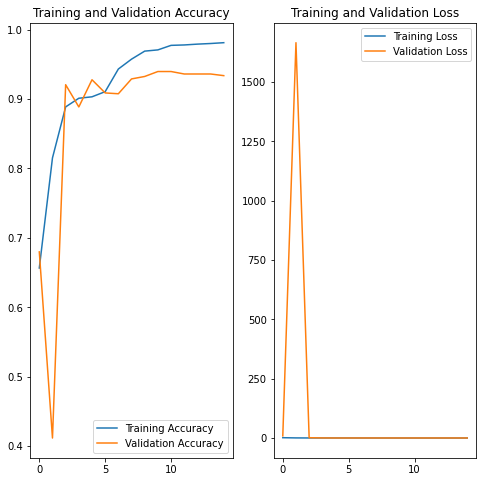

In [19]:
epochs=15
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [20]:
preformance = model.evaluate(val_ds)

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 1/27 [>.............................] - ETA: 32s - loss: 0.3146 - accuracy: 0.9062

Cleanup called...
Cleanup called...


 4/27 [===>..........................] - ETA: 3s - loss: 0.3876 - accuracy: 0.9141

Cleanup called...
Cleanup called...
Cleanup called...


 6/27 [=====>........................] - ETA: 3s - loss: 0.4697 - accuracy: 0.9010

Cleanup called...


 9/27 [=========>....................] - ETA: 2s - loss: 0.3937 - accuracy: 0.9132

Cleanup called...
Cleanup called...
Cleanup called...


11/27 [===========>..................] - ETA: 2s - loss: 0.3434 - accuracy: 0.9233

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


13/27 [=============>................] - ETA: 2s - loss: 0.3482 - accuracy: 0.9207

Cleanup called...
Cleanup called...
Cleanup called...


15/27 [===============>..............] - ETA: 1s - loss: 0.3120 - accuracy: 0.9292

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


16/27 [================>.............] - ETA: 1s - loss: 0.3466 - accuracy: 0.9277

Cleanup called...
Cleanup called...


18/27 [===================>..........] - ETA: 1s - loss: 0.3314 - accuracy: 0.9288

Cleanup called...
Cleanup called...


27/27 [==============================] - 5s 127ms/step - loss: 0.2763 - accuracy: 0.9336


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


actual label: normal
predicted label: normal


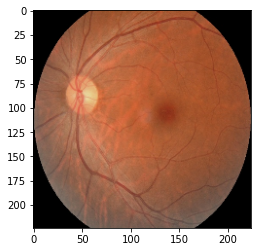

In [21]:
labels = train_ds.class_names
labels
for images_batch, labels_batch in val_ds.take(1):
    
    image = images_batch[0].numpy().astype('uint8')
    label = labels_batch[0].numpy()
    
    plt.imshow(image)
    print("actual label:", labels[label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:", labels[np.argmax(batch_prediction[0])])

In [22]:
from tensorflow import expand_dims, newaxis

def predict(model, img):
    
    img_array = img.numpy()
    img_array = expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = labels[np.argmax(predictions[0])]
    confidence = round( (np.max(predictions[0])), 2)
    
    return predicted_class, confidence

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


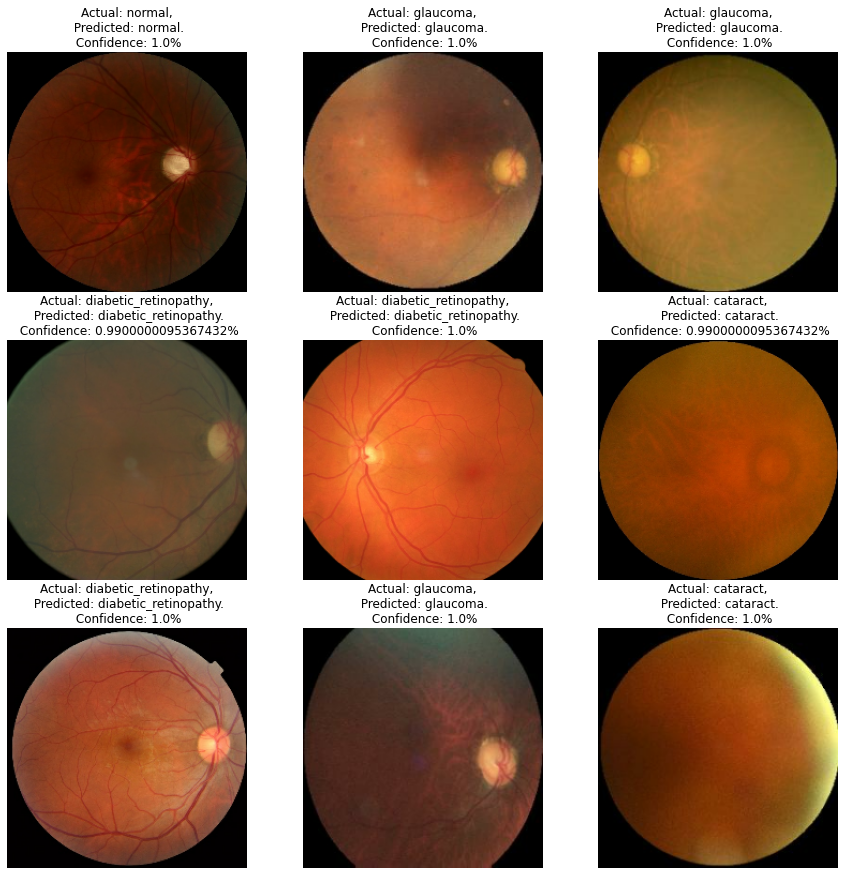

In [23]:
plt.figure(figsize=(15, 15))

for images, lbs in val_ds.take(1):
    for i in range(9):
        
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint32"))
        
        predicted_class, confidence = predict(model, images[i])
        actual_class = labels[lbs[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")